# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
# from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# import eli5
# from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

In [3]:
# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Data

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print('Train set shape: ', train.shape)
print('Test set shape: ', test.shape)
train.head()

Train set shape:  (8693, 14)
Test set shape:  (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Missing values

In [5]:
print('TRAIN SET MISSING VALUES:')
print(train.isna().sum())
print('')
print('TEST SET MISSING VALUES')
print(test.isna().sum())

TRAIN SET MISSING VALUES:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

TEST SET MISSING VALUES
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


### Almost every feature has missing values! How we deal with these values will be very important.

## Duplicates

In [6]:
train_duplicate = train.duplicated().sum()
test_duplicate = test.duplicated().sum()

print(f'Duplicates in train set: {train_duplicate}, ({np.round(100*train_duplicate/len(train), 1)}%)')
print('')
print(f'Duplicates in test set: {test_duplicate}, ({np.round(100*test_duplicate/len(test), 1)}%)')


Duplicates in train set: 0, (0.0%)

Duplicates in test set: 0, (0.0%)


## Cardinality of features

There are 6 continuous features, 4 categorical features (excluding the target) and 3 descriptive/qualitative features.

In [7]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

## Data types

In [8]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

We will need to transform the data to be numeric (int64 or float64) so that we can train machine learning models. These models (in general) don't work on text.

# EDA

### Target distribution

In [9]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

Text(0.5, 1.0, 'Target distribution')

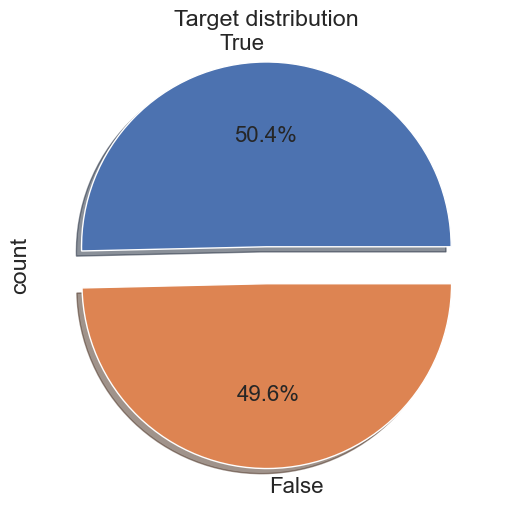

In [10]:
plt.figure(figsize=(6,6))

# Pie plot
train['Transported'].value_counts().plot.pie(
    explode=[0.1, 0.1],
    autopct='%1.1f%%',
    shadow=True,
    textprops={'fontsize': 16}
).set_title("Target distribution")

The target is highly balanced, so we luckily don't have to consider techniques like under/over-sampling.

### Continuous features

Text(0.5, 0, 'Age (years)')

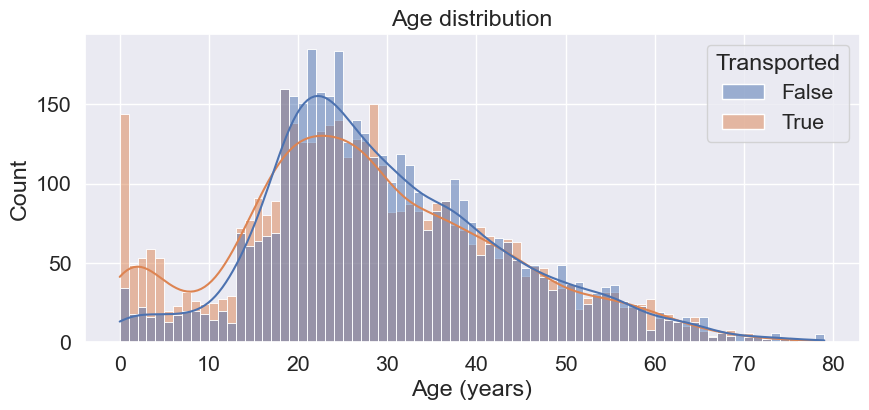

In [11]:
plt.figure(figsize=(10, 4))

# Histogram
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)

plt.title('Age distribution')
plt.xlabel('Age (years)')

Notes:

* 0-18 year olds were more likely to be transported than not.
* 18-25 year olds were less likely to be transported than not.
* Over 25 year old were about equally likely to be transported than not.


Insight:
* Create a new feature that indicates whether the passenger is a child, adolescent or adult.

In [12]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

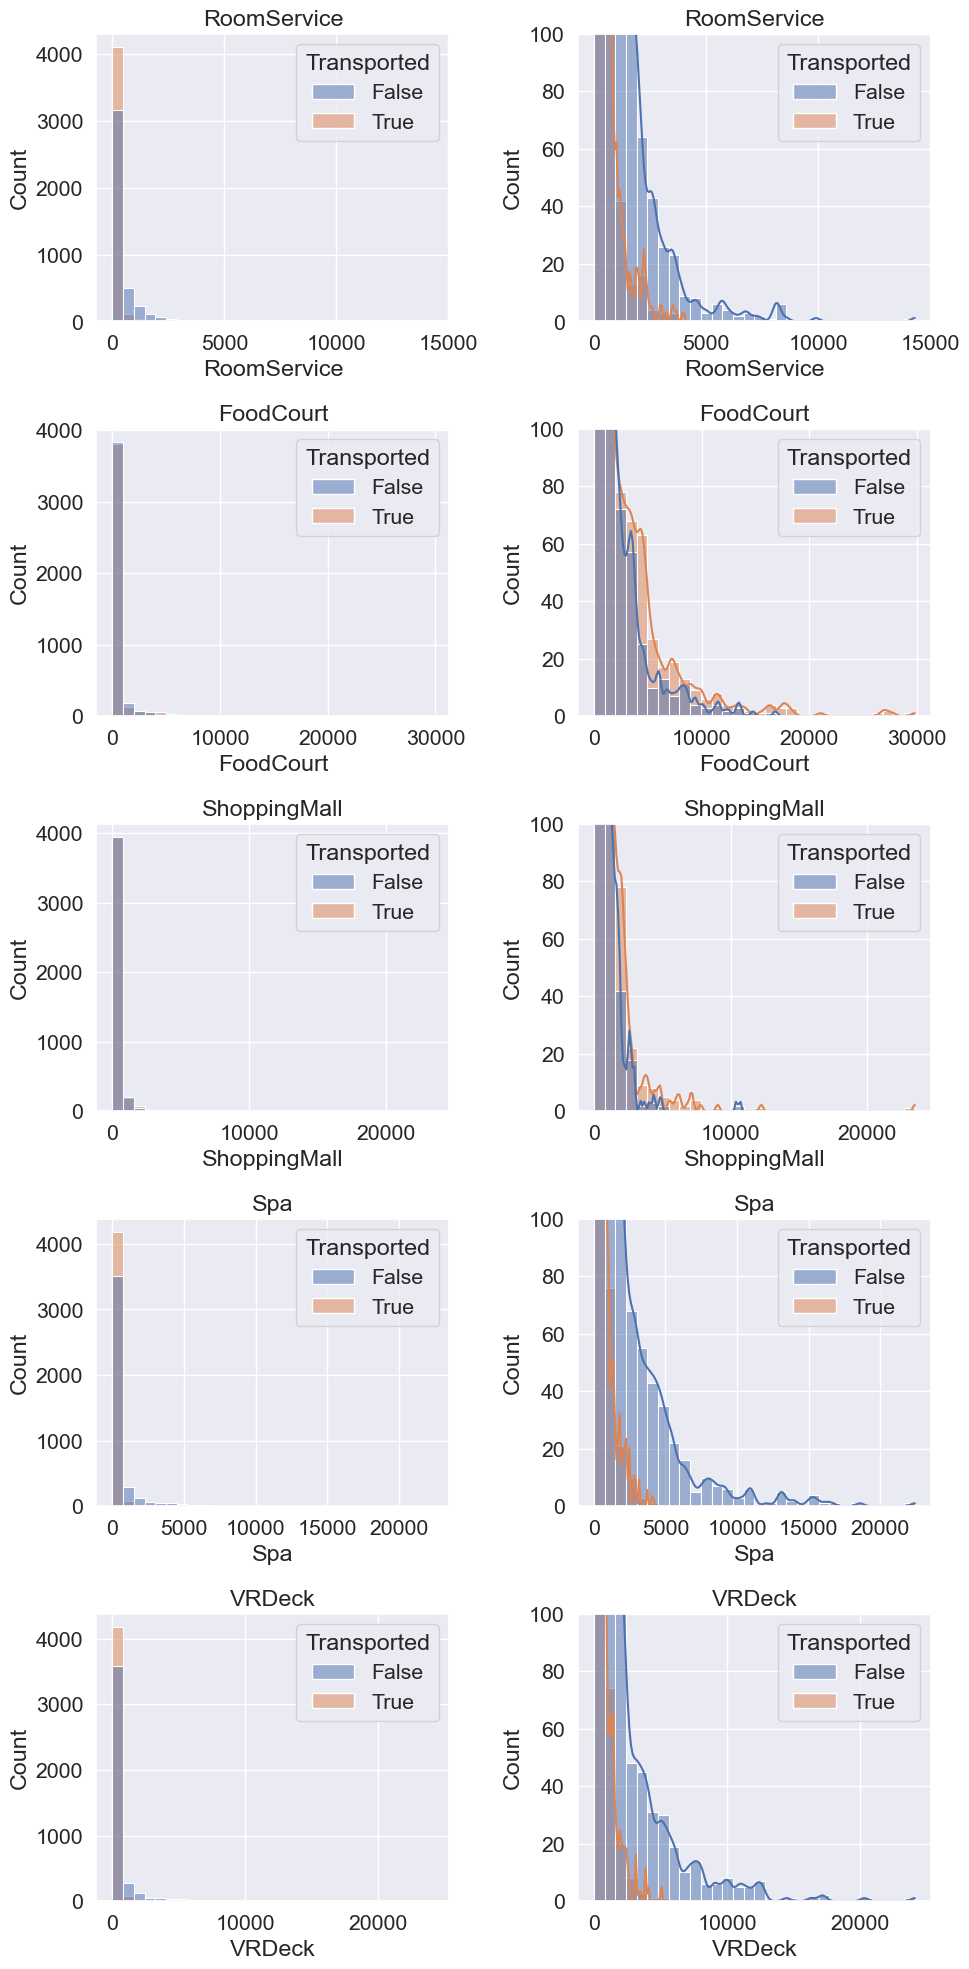

In [13]:
# Expenditure features
exp_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig = plt.figure(figsize=(10,20))

for i, var_name in enumerate(exp_feats):
    # left plot
    ax = fig.add_subplot(5, 2, 2*i + 1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)

    # right plot (truncated)
    ax = fig.add_subplot(5, 2, 2*i + 2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0, 100])
    ax.set_title(var_name)

fig.tight_layout()
plt.show()

Notes:
* most people don't spend any money (as we can see on the left).
* the distribution of spending decays exponentially (as we can see on the right).
* there are a small number of outliners.
* people who were transported tended to spend less.
* RoomService, Spa and VRDeck have different distributions to FoodCourt and ShoppingMall - we can think of this as luxury vs essential amenities.

Insight:
* create a new feature that tracks the total expenditure across all 5 amenities.
* create a binary feature to indicate if the person has not spent anything. (i.e. total expenditure is 0).
* take the log transform to reduce skew.

### Categorical features

In [14]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

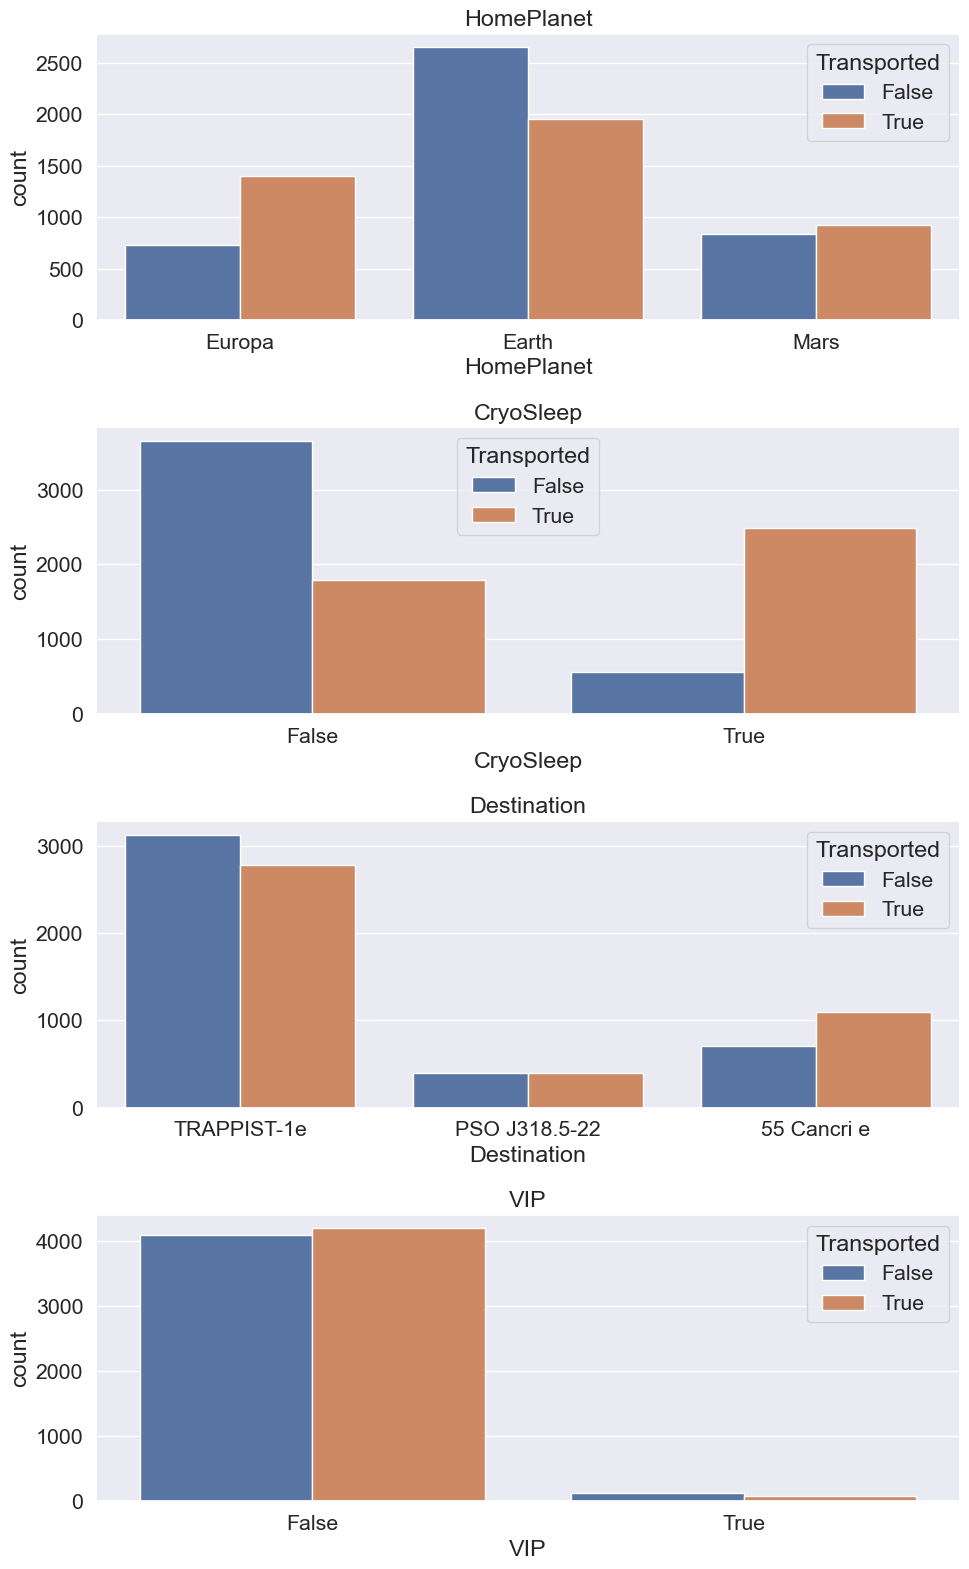

In [15]:
cat_feats = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# plot categorical features
fig = plt.figure(figsize=(10, 16))
for i, var_name in enumerate(cat_feats):
    ax = fig.add_subplot(4, 1, i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)

fig.tight_layout()
plt.show()

Notes:
* VIP does not appear to be a useful feature; the target split is more or less equal.
* CryoSleep appears to be a very useful feature in contrast.

Insights:
* We might consider dropping the VIP column to prevent overfitting.

### Qualitative features

we can't plot this data (yet). we need to transform it into more useful features.

In [16]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [17]:
qual_feats = ['PassengerId', 'Cabin', 'Name']

train[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


Insights:
* we can extract the group and group size from the PassengerId feature.
* we can extract the deck, number and side from the Cabin feature.
* we can extract the surname from the Name feature to identify families.

# Feature engineering

Better features make better models.

### Age status


In [18]:
# New features - training set
train['Age_group'] = np.nan
train.loc[train['Age']<=12, 'Age_group'] = 'Age_0-12'
train.loc[(train['Age']>12) & (train['Age']<18), 'Age_group'] = 'Age_13-17'
train.loc[(train['Age']>=18) & (train['Age']<=25), 'Age_group'] = 'Age_18-25'
train.loc[(train['Age']>25) & (train['Age']<=30), 'Age_group'] = 'Age_26-30'
train.loc[(train['Age']>30) & (train['Age']<=50), 'Age_group'] = 'Age_31-50'
train.loc[train['Age']>50, 'Age_group'] = 'Age_51+'

In [19]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'Age_group'],
      dtype='object')

In [20]:
train['Age_group'].head(10)

0    Age_31-50
1    Age_18-25
2      Age_51+
3    Age_31-50
4    Age_13-17
5    Age_31-50
6    Age_26-30
7    Age_26-30
8    Age_31-50
9    Age_13-17
Name: Age_group, dtype: object

In [21]:
# New features - test set
test['Age_group'] = np.nan
test.loc[test['Age']<=12, 'Age_group'] = 'Age_0-12'
test.loc[(test['Age']>12) & (test['Age']<18), 'Age_group'] = 'Age_13-17'
test.loc[(test['Age']>=18) & (test['Age']<=25), 'Age_group'] = 'Age_18-25'
test.loc[(test['Age']>25) & (test['Age']<=30), 'Age_group'] = 'Age_26-30'
test.loc[(test['Age']>30) & (test['Age']<=50), 'Age_group'] = 'Age_31-50'
test.loc[test['Age']>50, 'Age_group'] = 'Age_51+'

In [22]:
test.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Age_group'],
      dtype='object')

In [23]:
test['Age_group'].head(10)

0    Age_26-30
1    Age_18-25
2    Age_31-50
3    Age_31-50
4    Age_18-25
5    Age_31-50
6    Age_18-25
7    Age_18-25
8    Age_18-25
9    Age_18-25
Name: Age_group, dtype: object

Text(0.5, 1.0, 'Age group distribution')

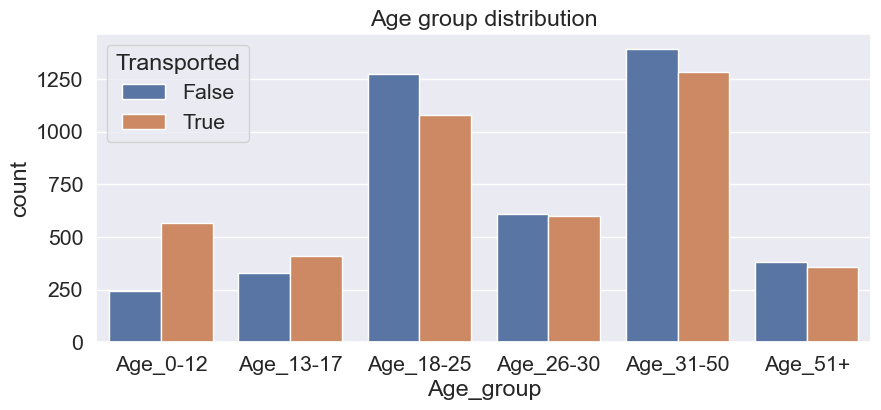

In [24]:
# plot distribution of new features
plt.figure(figsize=(10, 4))
g = sns.countplot(data=train, x='Age_group', hue='Transported', 
                  order=['Age_0-12', 'Age_13-17', 'Age_18-25', 'Age_26-30', 'Age_31-50', 'Age_51+'])
plt.title('Age group distribution')

### Expenditure

Calculate total expenditure and identify passengers with no expenditure.

In [25]:
exp_feats

['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [26]:
# New features - training set
train['Expenditure'] = train[exp_feats].sum(axis = 1)
train['No_spending'] = (train['Expenditure'] == 0).astype(int)

In [27]:
train[['Expenditure', 'No_spending']].head(10)

,Expenditure,No_spending
0,0.0,1
1,736.0,0
2,10383.0,0
3,5176.0,0
4,1091.0,0
5,774.0,0
6,1584.0,0
7,0.0,1
8,1018.0,0
9,0.0,1


In [28]:
# New features - test set
test['Expenditure'] = test[exp_feats].sum(axis = 1)
test['No_spending'] = (test['Expenditure'] == 0).astype(int)

In [29]:
test[['Expenditure', 'No_spending']].head(10)


,Expenditure,No_spending
0,0.0,1
1,2832.0,0
2,0.0,1
3,7418.0,0
4,645.0,0
5,2051.0,0
6,0.0,1
7,0.0,1
8,0.0,1
9,639.0,0


In [30]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'Age_group', 'Expenditure', 'No_spending'],
      dtype='object')

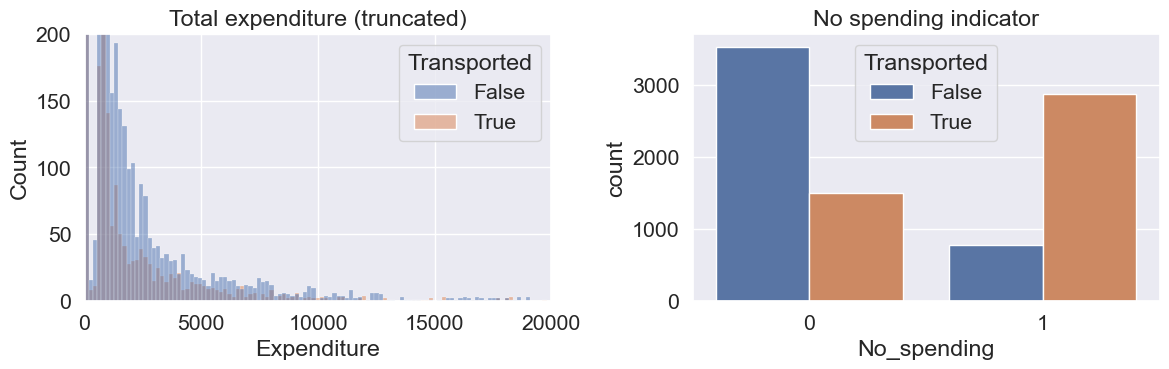

In [31]:
# plot distribution of new features
fig = plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
sns.histplot(data = train, x = 'Expenditure', hue = 'Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0, 200])
plt.xlim([0, 20000])

plt.subplot(1,2,2)
sns.countplot(data = train, x = 'No_spending', hue = 'Transported')
plt.title('No spending indicator')

fig.tight_layout()

### Passenger group

In [32]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'Age_group', 'Expenditure', 'No_spending'],
      dtype='object')

In [33]:
train['PassengerId'].head(10)

0    0001_01
1    0002_01
2    0003_01
3    0003_02
4    0004_01
5    0005_01
6    0006_01
7    0006_02
8    0007_01
9    0008_01
Name: PassengerId, dtype: object

In [34]:
# New feature - Group
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

In [35]:
train['Group'].head(10)

0    1
1    2
2    3
3    3
4    4
5    5
6    6
7    6
8    7
9    8
Name: Group, dtype: int32

In [36]:
# New feature - Group size
train['Group_size'] = train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['Group_size'] = test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

In [37]:
train[['Group','Group_size']].head(15)

,Group,Group_size
0,1,1
1,2,1
2,3,2
3,3,2
4,4,1
5,5,1
6,6,2
7,6,2
8,7,1
9,8,3


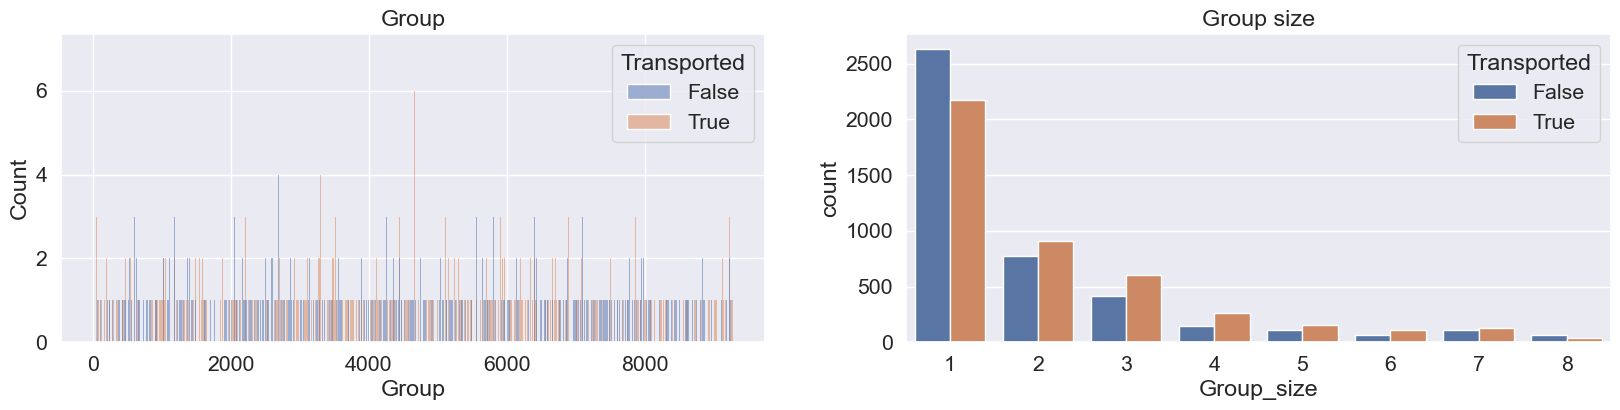

In [38]:
# plot distribution of new features
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
sns.histplot(data=train, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1, 2, 2)
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

In [39]:
train['Group'].nunique()

6217

We can't really use the Group feature in our models because it has too big of a cardinality (6217) and would explode the number of dimensions with one-hot encoding.

The Group size on the other hand should be a useful feature. In fact, we can compress the feature further by creating a 'Solo' column that tracks whether someone is travelling on their own or not. The figure on the right shows that group size = 1 is less likely to be transported than group size > 1.

In [40]:
# New feature
train['Solo'] = (train['Group_size']==1).astype(int)
test['Solo'] = (test['Group_size']==1).astype(int)

In [41]:
train[['Group','Group_size', 'Solo']].head()

,Group,Group_size,Solo
0,1,1,1
1,2,1,1
2,3,2,0
3,3,2,0
4,4,1,1


(0.0, 3000.0)

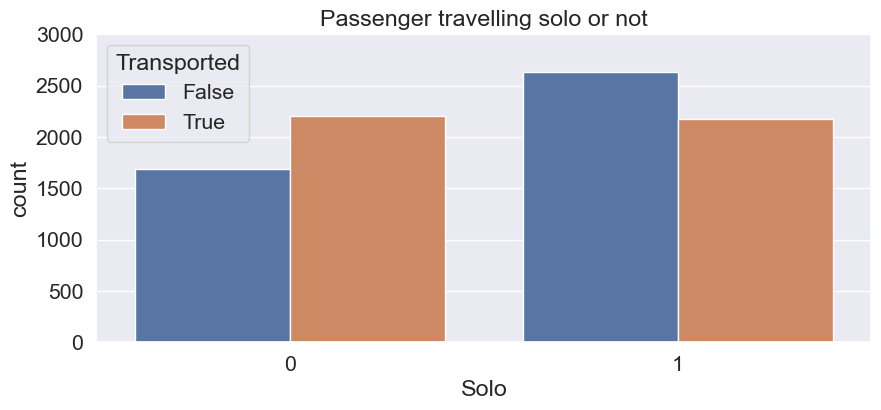

In [42]:
# New feature distribution
plt.figure(figsize=(10, 4))
sns.countplot(data=train, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0, 3000])

### Cabin location

extract deck, number and side from cabin feature.

In [43]:
train['Cabin'].head()

0    B/0/P
1    F/0/S
2    A/0/S
3    A/0/S
4    F/1/S
Name: Cabin, dtype: object

In [44]:
train['Cabin'].tail()

8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, dtype: object

In [45]:
train['Cabin'].isna().sum()

199

In [46]:
# Replace NaN with outliers for now
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

In [47]:
train['Cabin'].isna().sum()

0

In [48]:
# New features - training set
train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

# New features - test set
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

In [49]:
train[['Cabin', 'Cabin_deck', 'Cabin_number', 'Cabin_side']].head()

,Cabin,Cabin_deck,Cabin_number,Cabin_side
0,B/0/P,B,0,P
1,F/0/S,F,0,S
2,A/0/S,A,0,S
3,A/0/S,A,0,S
4,F/1/S,F,1,S


In [50]:
# Put NaN back in
train.loc[train['Cabin_deck'] == 'Z', 'Cabin_deck'] = np.nan
train.loc[train['Cabin_number'] == 9999, 'Cabin_number'] = np.nan
train.loc[train['Cabin_side'] == 'Z', 'Cabin_side'] = np.nan

test.loc[test['Cabin_deck'] == 'Z', 'Cabin_deck'] = np.nan
test.loc[test['Cabin_number'] == 9999, 'Cabin_number'] = np.nan
test.loc[test['Cabin_side'] == 'Z', 'Cabin_side'] = np.nan

In [51]:
train[['Cabin', 'Cabin_deck', 'Cabin_number', 'Cabin_side']].head(20)


,Cabin,Cabin_deck,Cabin_number,Cabin_side
0,B/0/P,B,0.0,P
1,F/0/S,F,0.0,S
2,A/0/S,A,0.0,S
3,A/0/S,A,0.0,S
4,F/1/S,F,1.0,S
5,F/0/P,F,0.0,P
6,F/2/S,F,2.0,S
7,G/0/S,G,0.0,S
8,F/3/S,F,3.0,S
9,B/1/P,B,1.0,P


In [52]:
# Drop Cabin (we don't need it anymore)
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

In [53]:
cabin_deck_arr = train['Cabin_deck'].unique()
cabin_deck_list = cabin_deck_arr.tolist()
cabin_deck_list

['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T']

In [54]:
cabin_deck_list = [x for x in cabin_deck_list if x == x]
cabin_deck_list

['B', 'F', 'A', 'G', 'E', 'D', 'C', 'T']

In [55]:
cabin_deck_list.sort()
cabin_deck_list

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']

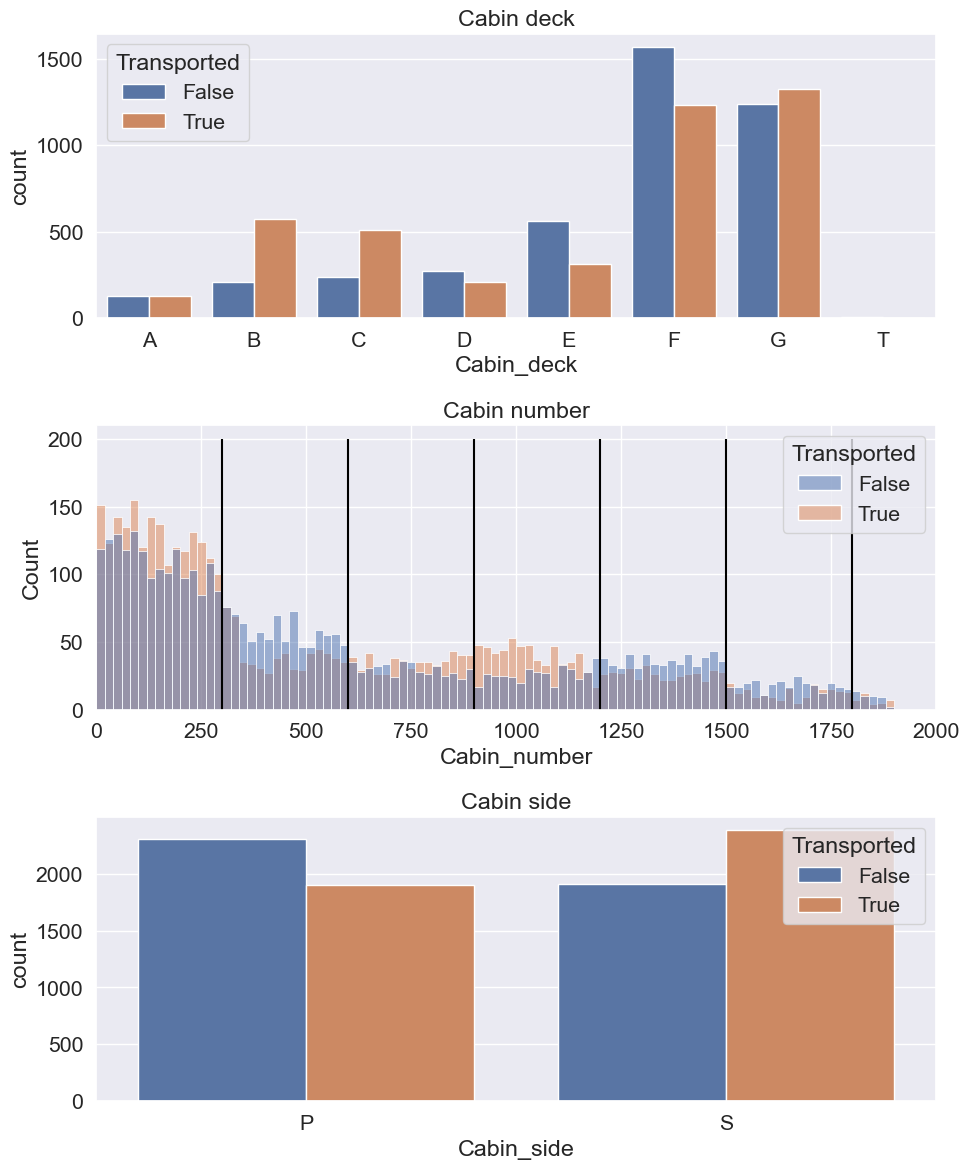

In [56]:
# Plot distribution of new features
fig = plt.figure(figsize=(10, 12))

plt.subplot(3,1,1)
sns.countplot(data=train, x='Cabin_deck', hue='Transported', order=cabin_deck_list)
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train, x='Cabin_number', hue='Transported', binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0, 2000])

plt.subplot(3,1,3)
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

In [57]:
t_count = (train['Cabin_deck'] == 'T').sum()
t_count

5

It appears that Cabin_number is grouped into chunks of 300 cabins. This means we can compress this feature into a categorical one, which indicates which chunk each passenger is in.

The cabin deck 'T' seems to be an outlier (there are only 5 samples).

In [58]:
# New features - training set
train['Cabin_region1'] = (train['Cabin_number']<300).astype(int) # one-hot encoding
train['Cabin_region2'] = ((train['Cabin_number']>=300) & (train['Cabin_number']<600)).astype(int)
train['Cabin_region3'] = ((train['Cabin_number']>=600) & (train['Cabin_number']<900)).astype(int)
train['Cabin_region4'] = ((train['Cabin_number']>=900) & (train['Cabin_number']<1200)).astype(int)
train['Cabin_region5'] = ((train['Cabin_number']>=1200) & (train['Cabin_number']<1500)).astype(int)
train['Cabin_region6'] = ((train['Cabin_number']>=1500) & (train['Cabin_number']<1800)).astype(int)
train['Cabin_region7'] = (train['Cabin_number']>=1800).astype(int)

# New features - test set
test['Cabin_region1'] = (test['Cabin_number']<300).astype(int) # one-hot encoding
test['Cabin_region2'] = ((test['Cabin_number']>=300) & (test['Cabin_number']<600)).astype(int)
test['Cabin_region3'] = ((test['Cabin_number']>=600) & (test['Cabin_number']<900)).astype(int)
test['Cabin_region4'] = ((test['Cabin_number']>=900) & (test['Cabin_number']<1200)).astype(int)
test['Cabin_region5'] = ((test['Cabin_number']>=1200) & (test['Cabin_number']<1500)).astype(int)
test['Cabin_region6'] = ((test['Cabin_number']>=1500) & (test['Cabin_number']<1800)).astype(int)
test['Cabin_region7'] = (test['Cabin_number']>=1800).astype(int)


In [59]:
train[['Cabin_number', 'Cabin_region1']].tail(15)

,Cabin_number,Cabin_region1
8678,607.0,0
8679,607.0,0
8680,1505.0,0
8681,1497.0,0
8682,1507.0,0
8683,1894.0,0
8684,1508.0,0
8685,97.0,1
8686,97.0,1
8687,97.0,1


Text(0.5, 1.0, 'Cabin regions')

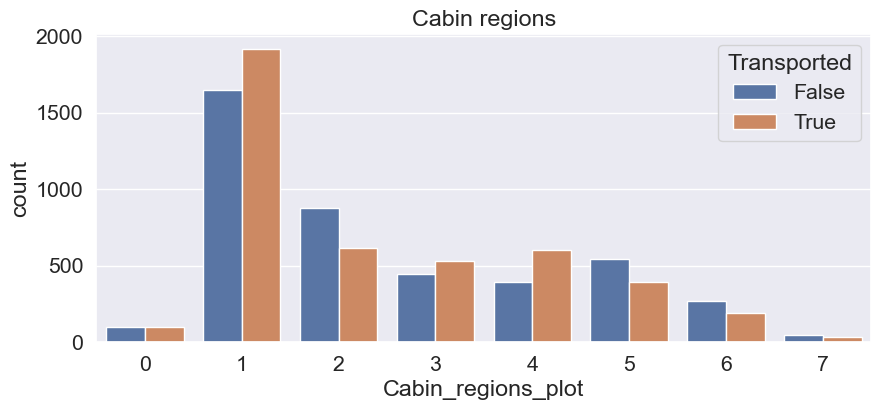

In [60]:
# Plot distribution of new features

plt.figure(figsize=(10, 4))
train['Cabin_regions_plot'] = (train['Cabin_region1'] + 2*train['Cabin_region2'] + 3*train['Cabin_region3']
                              + 4*train['Cabin_region4'] + 5*train['Cabin_region5'] + 6*train['Cabin_region6']
                              + 7*train['Cabin_region7']).astype(int)
sns.countplot(data=train, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')

In [61]:
train[['Cabin_number', 'Cabin_region1', 'Cabin_regions_plot']].tail(15)

,Cabin_number,Cabin_region1,Cabin_regions_plot
8678,607.0,0,3
8679,607.0,0,3
8680,1505.0,0,6
8681,1497.0,0,5
8682,1507.0,0,6
8683,1894.0,0,7
8684,1508.0,0,6
8685,97.0,1,1
8686,97.0,1,1
8687,97.0,1,1


In [62]:
zero_count = (train['Cabin_regions_plot'] == 0).sum()
zero_count

199

In [63]:
rows_with_zero = train.loc[train['Cabin_regions_plot'] == 0]
rows_with_zero['Cabin_number'].head()

15    NaN
93    NaN
103   NaN
222   NaN
227   NaN
Name: Cabin_number, dtype: float64

In [64]:
train.drop('Cabin_regions_plot', axis=1, inplace=True)

In [65]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name',
       'Transported', 'Age_group', 'Expenditure', 'No_spending', 'Group',
       'Group_size', 'Solo', 'Cabin_deck', 'Cabin_number', 'Cabin_side',
       'Cabin_region1', 'Cabin_region2', 'Cabin_region3', 'Cabin_region4',
       'Cabin_region5', 'Cabin_region6', 'Cabin_region7'],
      dtype='object')

### Last name

calculate family size from last name

In [66]:
# replace NaN with outliers for now
train['Name'].fillna('Unknown Unknown', inplace=True)
test['Name'].fillna('Unknown Unknown', inplace=True)

In [67]:
# New feature - Surname
train['Surname'] = train['Name'].str.split().str[-1]
test['Surname'] = test['Name'].str.split().str[-1]

# New feature - Family size
train['Family_size'] = train['Surname'].map(lambda x: pd.concat([train['Surname'], test['Surname']]).value_counts()[x])
test['Family_size'] = test['Surname'].map(lambda x: pd.concat([train['Surname'], test['Surname']]).value_counts()[x])

In [68]:
train[['Surname', 'Family_size']].head(10)

,Surname,Family_size
0,Ofracculy,3
1,Vines,4
2,Susent,7
3,Susent,7
4,Santantines,9
5,Hinetthews,10
6,Jacostaffey,9
7,Jacostaffey,9
8,Beston,5
9,Flatic,3


In [69]:
rows_with_nan = train.loc[train['Surname'] == 'Unknown']
rows_with_nan

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Surname,Family_size
27,0022_01,Mars,False,TRAPPIST-1e,21.0,False,980.0,2.0,69.0,0.0,...,P,1,0,0,0,0,0,0,Unknown,294
58,0064_01,Mars,True,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,...,S,1,0,0,0,0,0,0,Unknown,294
65,0069_01,Earth,False,TRAPPIST-1e,42.0,False,887.0,0.0,9.0,6.0,...,S,1,0,0,0,0,0,0,Unknown,294
77,0082_03,Mars,False,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,0.0,...,P,1,0,0,0,0,0,0,Unknown,294
101,0108_02,Earth,False,TRAPPIST-1e,31.0,False,562.0,0.0,326.0,0.0,...,S,1,0,0,0,0,0,0,Unknown,294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8629,9205_02,Europa,True,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,...,P,0,1,0,0,0,0,0,Unknown,294
8631,9208_01,Earth,True,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,0.0,...,S,0,0,0,0,1,0,0,Unknown,294
8636,9218_01,Europa,True,55 Cancri e,43.0,False,0.0,0.0,0.0,0.0,...,S,0,1,0,0,0,0,0,Unknown,294
8652,9230_01,Europa,False,TRAPPIST-1e,36.0,True,0.0,5600.0,715.0,2868.0,...,S,0,1,0,0,0,0,0,Unknown,294


In [70]:
rows_with_more_than_100 = train.loc[train['Family_size'] > 100]
rows_with_more_than_100

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Surname,Family_size
27,0022_01,Mars,False,TRAPPIST-1e,21.0,False,980.0,2.0,69.0,0.0,...,P,1,0,0,0,0,0,0,Unknown,294
58,0064_01,Mars,True,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,...,S,1,0,0,0,0,0,0,Unknown,294
65,0069_01,Earth,False,TRAPPIST-1e,42.0,False,887.0,0.0,9.0,6.0,...,S,1,0,0,0,0,0,0,Unknown,294
77,0082_03,Mars,False,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,0.0,...,P,1,0,0,0,0,0,0,Unknown,294
101,0108_02,Earth,False,TRAPPIST-1e,31.0,False,562.0,0.0,326.0,0.0,...,S,1,0,0,0,0,0,0,Unknown,294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8629,9205_02,Europa,True,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,...,P,0,1,0,0,0,0,0,Unknown,294
8631,9208_01,Earth,True,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,0.0,...,S,0,0,0,0,1,0,0,Unknown,294
8636,9218_01,Europa,True,55 Cancri e,43.0,False,0.0,0.0,0.0,0.0,...,S,0,1,0,0,0,0,0,Unknown,294
8652,9230_01,Europa,False,TRAPPIST-1e,36.0,True,0.0,5600.0,715.0,2868.0,...,S,0,1,0,0,0,0,0,Unknown,294


In [71]:
# Put NaN back in
train.loc[train['Surname']=='Unknown', 'Family_size']=np.nan
train.loc[train['Surname']=='Unknown', 'Surname']=np.nan

test.loc[test['Surname']=='Unknown', 'Family_size']=np.nan
test.loc[test['Surname']=='Unknown', 'Surname']=np.nan

In [72]:
rows_with_nan = train[train['Surname'].isnull()]
rows_with_nan

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Surname,Family_size
27,0022_01,Mars,False,TRAPPIST-1e,21.0,False,980.0,2.0,69.0,0.0,...,P,1,0,0,0,0,0,0,NaN,NaN
58,0064_01,Mars,True,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,...,S,1,0,0,0,0,0,0,NaN,NaN
65,0069_01,Earth,False,TRAPPIST-1e,42.0,False,887.0,0.0,9.0,6.0,...,S,1,0,0,0,0,0,0,NaN,NaN
77,0082_03,Mars,False,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,0.0,...,P,1,0,0,0,0,0,0,NaN,NaN
101,0108_02,Earth,False,TRAPPIST-1e,31.0,False,562.0,0.0,326.0,0.0,...,S,1,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8629,9205_02,Europa,True,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,...,P,0,1,0,0,0,0,0,NaN,NaN
8631,9208_01,Earth,True,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,0.0,...,S,0,0,0,0,1,0,0,NaN,NaN
8636,9218_01,Europa,True,55 Cancri e,43.0,False,0.0,0.0,0.0,0.0,...,S,0,1,0,0,0,0,0,NaN,NaN
8652,9230_01,Europa,False,TRAPPIST-1e,36.0,True,0.0,5600.0,715.0,2868.0,...,S,0,1,0,0,0,0,0,NaN,NaN


In [73]:
# Drop name
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

In [74]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'Age_group', 'Expenditure', 'No_spending', 'Group',
       'Group_size', 'Solo', 'Cabin_deck', 'Cabin_number', 'Cabin_side',
       'Cabin_region1', 'Cabin_region2', 'Cabin_region3', 'Cabin_region4',
       'Cabin_region5', 'Cabin_region6', 'Cabin_region7', 'Surname',
       'Family_size'],
      dtype='object')

Text(0.5, 1.0, 'Family size')

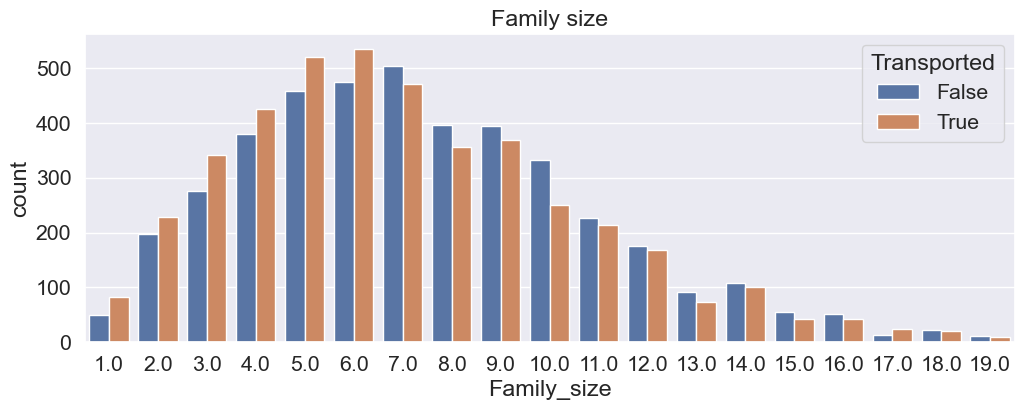

In [75]:
# New feature distribution
plt.figure(figsize=(12,4))
sns.countplot(data=train, x='Family_size', hue='Transported')
plt.title('Family size')

# Missing values

In [76]:
train['Transported'].head()

0    False
1     True
2    False
3    False
4     True
Name: Transported, dtype: bool

In [77]:
# Labels and features
y = train['Transported'].copy().astype(int)
X = train.drop('Transported', axis=1).copy()

# Concatenate dataframes
# combine train and test, it will make it easier to fill missing values
data = pd.concat([X, test], axis=0).reset_index(drop=True)

## Explore missing values

In [78]:
na_cols = data.columns[data.isna().any()].tolist()

na_cols

['HomePlanet',
 'CryoSleep',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Age_group',
 'Cabin_deck',
 'Cabin_number',
 'Cabin_side',
 'Surname',
 'Family_size']

In [79]:
# Missing values summary
mv = pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing'] = np.round(100 * mv['Number_missing']/len(data), 2)
mv

,Number_missing,Percentage_missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


In [80]:
train[na_cols].isna().T

,0,1,2,3,4,5,6,7,8,9,...,8683,8684,8685,8686,8687,8688,8689,8690,8691,8692
HomePlanet,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
CryoSleep,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
Destination,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Age,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
VIP,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
RoomService,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
FoodCourt,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ShoppingMall,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Spa,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
VRDeck,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


Text(0.5, 1.0, 'Heatmap of missing values')

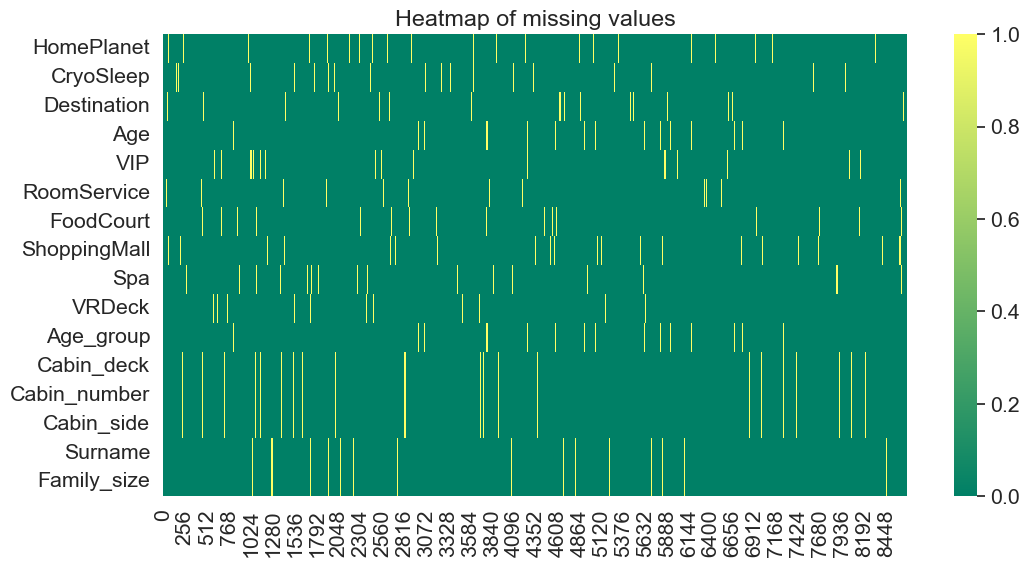

In [81]:
# Heatmap of missing values
plt.figure(figsize=(12, 6))
sns.heatmap(train[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values')

Missing values make up about 2% of the data, which is a relatively small amount. For the most part, they don't seem to be happening at the same time (except the features made from splitting Cabin and Name).

In [82]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'Age_group', 'Expenditure', 'No_spending', 'Group',
       'Group_size', 'Solo', 'Cabin_deck', 'Cabin_number', 'Cabin_side',
       'Cabin_region1', 'Cabin_region2', 'Cabin_region3', 'Cabin_region4',
       'Cabin_region5', 'Cabin_region6', 'Cabin_region7', 'Surname',
       'Family_size'],
      dtype='object')

In [83]:
train['na_count'] = train.isna().sum(axis = 1)
train['na_count'].head(15)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     1
8     0
9     0
10    1
11    0
12    0
13    0
14    0
Name: na_count, dtype: int64

Text(0.5, 1.0, 'Number of missing entries by passenger')

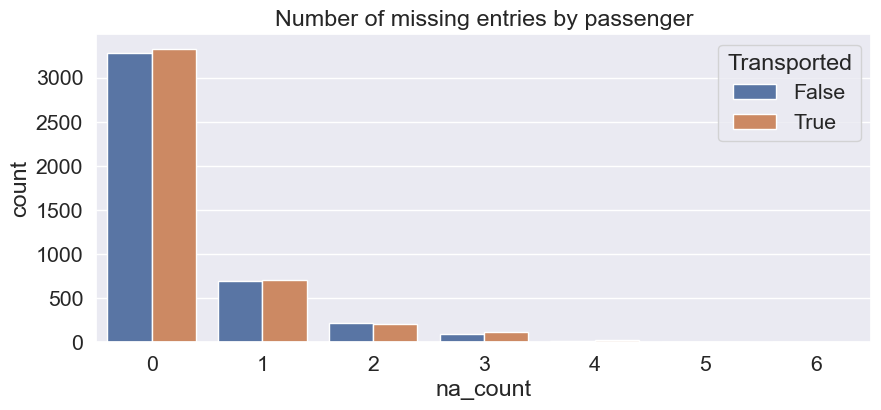

In [84]:
# Countplot of number of missing values by passenger

plt.figure(figsize=(10, 4))
sns.countplot(data=train, x='na_count', hue='Transported')
plt.title('Number of missing entries by passenger')

In [85]:
greater_than_zero_count = (train['na_count'] > 0).sum()
greater_than_zero_count

2087

In [86]:
missing_pert = np.round(100 * greater_than_zero_count/len(train), 2)
missing_pert

24.01

Notes:
* Missing values are independent of the target and for the most part are isolated.
* Even though only 2% of the data is missing, about 25% of all passengers have at least 1 missing value.
* PassengerId is the only original feature to not have any missing values.

Insight:
* Since most of the missing values are isolated, it makes sense to try to fill these in as opposed to just dropping rows.
* If there is a relationship between PassengerId and other features, we can fill missing values according to this column.

### Strategy

The easiest way to deal with missing values is to just use the median for continuous features and the mode for categorical features. This will work 'well enough' but if we want to maximise the accuracy of our models, then we need to look for patterns within the missing data.

The way to do this is by looking at the joint distribution of features, e.g. do passengers from the same group tend to come from the same family? There are obviously many combinations so we will just summarize the useful trends I and others have found.

In [87]:
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Age_group', 'Expenditure', 'No_spending', 'Group', 'Group_size',
       'Solo', 'Cabin_deck', 'Cabin_number', 'Cabin_side', 'Cabin_region1',
       'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5',
       'Cabin_region6', 'Cabin_region7', 'Surname', 'Family_size'],
      dtype='object')

Group is extracted from the PassengerId feature.

In [88]:
# Joint distribution of Group and HomePlanet
GHP_gb = data.groupby(['Group', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head(15)

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,2.0,0.0,0.0
7,1.0,0.0,0.0
8,0.0,3.0,0.0
9,0.0,0.0,1.0


In [89]:
greater_than_zero_counts = (GHP_gb > 0).sum(axis=1)
greater_than_zero_counts.head(15)

Group
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
dtype: int64

In [90]:
type(greater_than_zero_counts)

pandas.core.series.Series

Text(0.5, 1.0, 'Number of unique home planets per group')

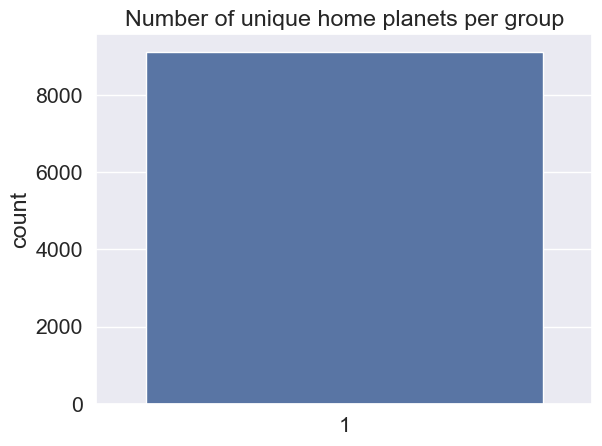

In [91]:
# Countplot of unique values
sns.countplot(x=greater_than_zero_counts)
plt.title('Number of unique home planets per group')

This shows that everyone in the same group comes from the same home planet. So we can fill the missing HomePlanet values according to the group.

In [92]:
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Age_group', 'Expenditure', 'No_spending', 'Group', 'Group_size',
       'Solo', 'Cabin_deck', 'Cabin_number', 'Cabin_side', 'Cabin_region1',
       'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5',
       'Cabin_region6', 'Cabin_region7', 'Surname', 'Family_size'],
      dtype='object')

In [93]:
# Missing values before
HP_bef = data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a group with known HomePlanet
GHP_index = data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

# Fill corresponding missing values
data.loc[GHP_index, 'HomePlanet'] = data.iloc[GHP_index, :]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:', HP_bef)
print('#HomePlanet missing values after:', data['HomePlanet'].isna().sum())


#HomePlanet missing values before: 288
#HomePlanet missing values after: 157


### HomePlanet and CabinDeck

In [94]:
# Joint distribution of CabinDeck and HomePlanet
CDHP_gb = data.groupby(['Cabin_deck', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
CDHP_gb

HomePlanet,Earth,Europa,Mars
Cabin_deck,,,
A,0.0,352.0,0.0
B,0.0,1137.0,0.0
C,0.0,1096.0,0.0
D,0.0,301.0,410.0
E,589.0,199.0,515.0
F,2437.0,0.0,1742.0
G,3731.0,0.0,0.0
T,0.0,10.0,0.0


<Axes: xlabel='Cabin_deck', ylabel='HomePlanet'>

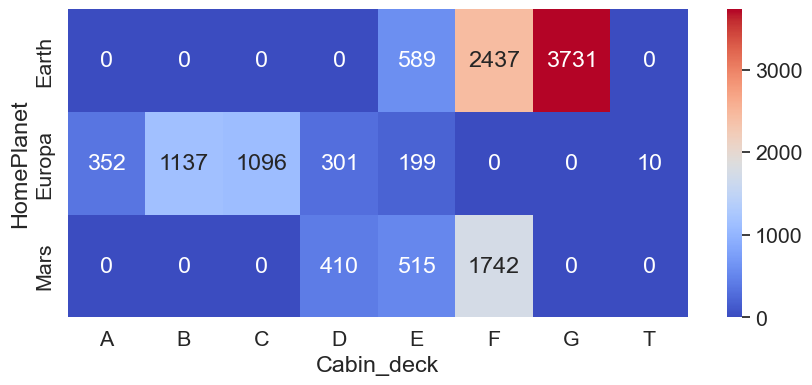

In [95]:
plt.figure(figsize=(10, 4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')

Notes:
* Passengers on decks A, B, C or T came from Europa.
* Passengers on deck G came from Earth.
* Passengers on deck D, E or F came from multiple planets.

In [96]:
# Missing values before
HP_bef = data['HomePlanet'].isna().sum()

# Decks A, B, C or T came from Europa
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet'] = 'Europa'

# Deck G came from Earth
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='G'), 'HomePlanet'] = 'Earth'

# Print number of missing values left
print('#HomePlanet missing values before:', HP_bef)
print('#HomePlanet missing values after:', data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 157
#HomePlanet missing values after: 94


### HomePlanet and Surname

In [97]:
# Joint distribution of Surname and HomePlanet
SHP_gb = data.groupby(['Surname', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
SHP_gb

HomePlanet,Earth,Europa,Mars
Surname,,,
Acobson,5.0,0.0,0.0
Acobsond,8.0,0.0,0.0
Adavisons,10.0,0.0,0.0
Adkinson,4.0,0.0,0.0
Admingried,0.0,4.0,0.0
...,...,...,...
Wynneyerson,2.0,0.0,0.0
Yanton,8.0,0.0,0.0
Yatters,8.0,0.0,0.0


In [98]:
SHP_unique_count = (SHP_gb>0).sum(axis=1)
SHP_unique_count

Surname
Acobson        1
Acobsond       1
Adavisons      1
Adkinson       1
Admingried     1
              ..
Wynneyerson    1
Yanton         1
Yatters        1
Yorkland       1
Youngrayes     1
Length: 2402, dtype: int64

Text(0.5, 1.0, 'Number of unique planets per surname')

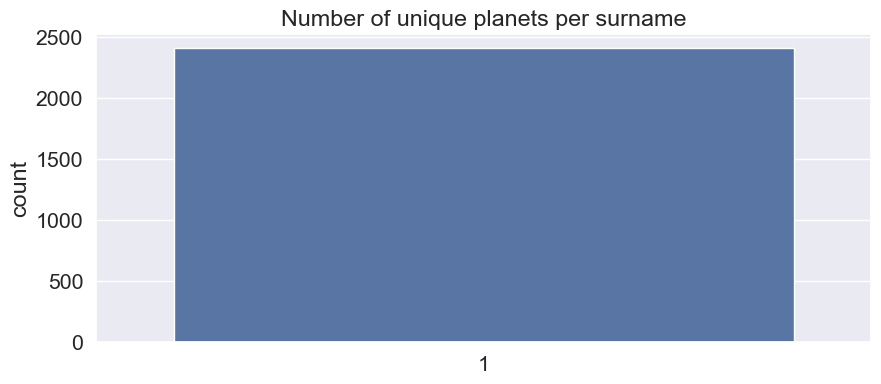

In [99]:
# Countplot of unique values
plt.figure(figsize=(10, 4))
sns.countplot(x=SHP_unique_count)
plt.title('Number of unique planets per surname')

Everyone with the same surname comes from the same home planet.

In [100]:
# Missing values before
HP_bef = data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a family with known HomePlanet
SHP_index = data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

# Fill corresponding missing values
data.loc[SHP_index, 'HomePlanet'] = data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:', HP_bef)
print('#HomePlanet missing values after:', data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 94
#HomePlanet missing values after: 10


In [101]:
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Age_group', 'Expenditure', 'No_spending', 'Group', 'Group_size',
       'Solo', 'Cabin_deck', 'Cabin_number', 'Cabin_side', 'Cabin_region1',
       'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5',
       'Cabin_region6', 'Cabin_region7', 'Surname', 'Family_size'],
      dtype='object')

In [102]:
# Only 10 HomePlanet missing values left

data[data['HomePlanet'].isna()][['PassengerId', 'HomePlanet', 'Destination', 'Cabin_deck']]

,PassengerId,HomePlanet,Destination,Cabin_deck
2274,2443_01,NaN,TRAPPIST-1e,D
2631,2817_01,NaN,TRAPPIST-1e,F
3091,3331_01,NaN,TRAPPIST-1e,F
4548,4840_01,NaN,TRAPPIST-1e,F
5762,6108_01,NaN,TRAPPIST-1e,F
8969,0616_01,NaN,TRAPPIST-1e,E
10583,4052_01,NaN,TRAPPIST-1e,D
11913,7065_01,NaN,TRAPPIST-1e,E
12551,8435_01,NaN,TRAPPIST-1e,F
12725,8775_01,NaN,TRAPPIST-1e,D


Everyone left is heading towards the same destination.

### HomePlanet and Destination

In [103]:
# Joint distribution of HomePlanet and Destination
HPD_gb = data.groupby(['HomePlanet', 'Destination'])['Destination'].size().unstack().fillna(0)
HPD_gb

Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
HomePlanet,,,
Earth,1000,1085,4778
Europa,1341,29,1769
Mars,300,70,2314


<Axes: xlabel='HomePlanet', ylabel='Destination'>

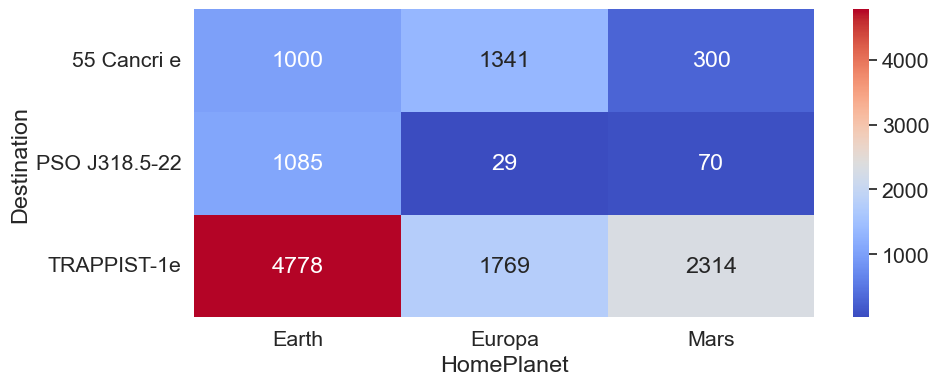

In [104]:
plt.figure(figsize=(10, 4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')

Most people heading towards TRAPPIST-1e came from Earth so it makes sense to guess they came from there. But from earlier, no one on deck D came from Earth so we need to filter these out.

In [105]:
# Missing values before
HP_bef = data['HomePlanet'].isna().sum()

# Fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
data.loc[(data['HomePlanet'].isna()) & ~(data['Cabin_deck']=='D'), 'HomePlanet'] = 'Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='D'), 'HomePlanet'] = 'Mars'

# Print number of missing values left
print('#HomePlanet missing values before:', HP_bef)
print('#HomePlanet missing values after:', data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 10
#HomePlanet missing values after: 0


We are done with HomePlanet.

### Destination

Since the majority of passengers are heading towards TRAPPIST-1e, we will just impute this value (i.e. the mode). A better rule hasn't been found at this stage.

In [106]:
# Missing values before
D_bef = data['Destination'].isna().sum()

# Fill missing Destination values with mode
data.loc[(data['Destination'].isna()), 'Destination'] = 'TRAPPIST-1e'

# Print number of missing values left
print('#Destination missing values before:', D_bef)
print('#Destination missing values after:', data['Destination'].isna().sum())

#Destination missing values before: 274
#Destination missing values after: 0


### Surname and group

The reason we are filling missing surnames is because we will use surnames later to fill missing values of other features. It also means we can improve the accuracy of family size feature.

In [107]:
# Joint distribution of Group and Surname
GSN_gb = data[data['Group_size']>1].groupby(['Group', 'Surname'])['Surname'].size().unstack().fillna(0)

GSN_gb

Surname,Acobson,Acobsond,Adavisons,Admingried,Aginge,Ailled,Aillyber,Ainatint,Aindlylid,Ainserfle,...,Woody,Wooes,Wooterston,Workmans,Workmanson,Wriggins,Yanton,Yatters,Yorkland,Youngrayes
Group,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
group_surname_unique_count = (GSN_gb>0).sum(axis=1)
group_surname_unique_count

Group
3       1
6       1
8       1
17      1
20      3
       ..
9266    1
9267    1
9272    1
9275    1
9280    1
Length: 2135, dtype: int64

Text(0.5, 1.0, 'Number of unique surnames by group')

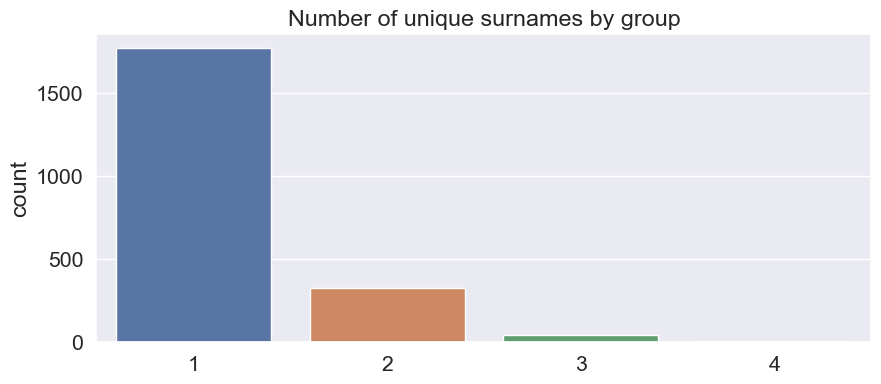

In [109]:
# Countplot of unique values
plt.figure(figsize=(10, 4))
sns.countplot(x=group_surname_unique_count)
plt.title('Number of unique surnames by group')

The majority of groups contain only 1 family. So let's fill missing surnames according to the majority surname in that group.

In [110]:
# Missing values before
SN_bef = data['Surname'].isna().sum()

# Passengers with missing Surname and in a group with known majority Surname
GSN_index = data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

# Fill corresponding missing values
data.loc[GSN_index, 'Surname'] = data.iloc[GSN_index, :]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Surname missing values before:', SN_bef)
print('#Surname missing values after:', data['Surname'].isna().sum())

#Surname missing values before: 294
#Surname missing values after: 155


That is the best we can do. We don't have to get rid of all of these missing values because we will end up dropping the surname feature anyway. However, we can update the family size feature.

In [111]:
# Replace NaN with outliers (so we can use map)
data['Surname'].fillna('Unknown', inplace=True)

# Update family size feature
data['Family_size'] = data['Surname'].map(lambda x: data['Surname'].value_counts()[x])

# Say unknown surname means no family
data.loc[data['Surname']=='Unknown', 'Family_size'] = 0

# Put NaN back in place of outliers
data.loc[data['Surname']=='Unknown', 'Surname'] = np.nan

In [112]:
nan_rows = data[data['Surname'].isna()]
nan_rows

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Surname,Family_size
27,0022_01,Mars,False,TRAPPIST-1e,21.0,False,980.0,2.0,69.0,0.0,...,P,1,0,0,0,0,0,0,NaN,0
65,0069_01,Earth,False,TRAPPIST-1e,42.0,False,887.0,0.0,9.0,6.0,...,S,1,0,0,0,0,0,0,NaN,0
126,0136_01,Earth,False,PSO J318.5-22,47.0,False,97.0,418.0,126.0,25.0,...,S,1,0,0,0,0,0,0,NaN,0
165,0190_01,Earth,True,55 Cancri e,11.0,False,0.0,0.0,0.0,0.0,...,S,1,0,0,0,0,0,0,NaN,0
331,0372_01,Earth,False,TRAPPIST-1e,24.0,False,0.0,5.0,0.0,2766.0,...,P,1,0,0,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12345,7956_01,Earth,False,TRAPPIST-1e,21.0,NaN,0.0,599.0,0.0,21.0,...,P,0,0,0,0,1,0,0,NaN,0
12452,8201_01,Europa,True,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,...,P,1,0,0,0,0,0,0,NaN,0
12551,8435_01,Earth,NaN,TRAPPIST-1e,19.0,False,162.0,11.0,0.0,0.0,...,P,0,0,0,0,0,1,0,NaN,0
12749,8810_01,Mars,False,TRAPPIST-1e,45.0,True,1233.0,0.0,0.0,99.0,...,S,0,0,0,0,0,1,0,NaN,0


### Cabin and Group

In [113]:
# Joint distribution of Group and Cabin features
GCD_gb = data[data['Group_size']>1].groupby(['Group', 'Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
GCN_gb = data[data['Group_size']>1].groupby(['Group', 'Cabin_number'])['Cabin_number'].size().unstack().fillna(0)
GCS_gb = data[data['Group_size']>1].groupby(['Group', 'Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

In [114]:
GCD_unique = (GCD_gb>0).sum(axis=1)
GCN_unique = (GCN_gb>0).sum(axis=1)
GCS_unique = (GCS_gb>0).sum(axis=1)

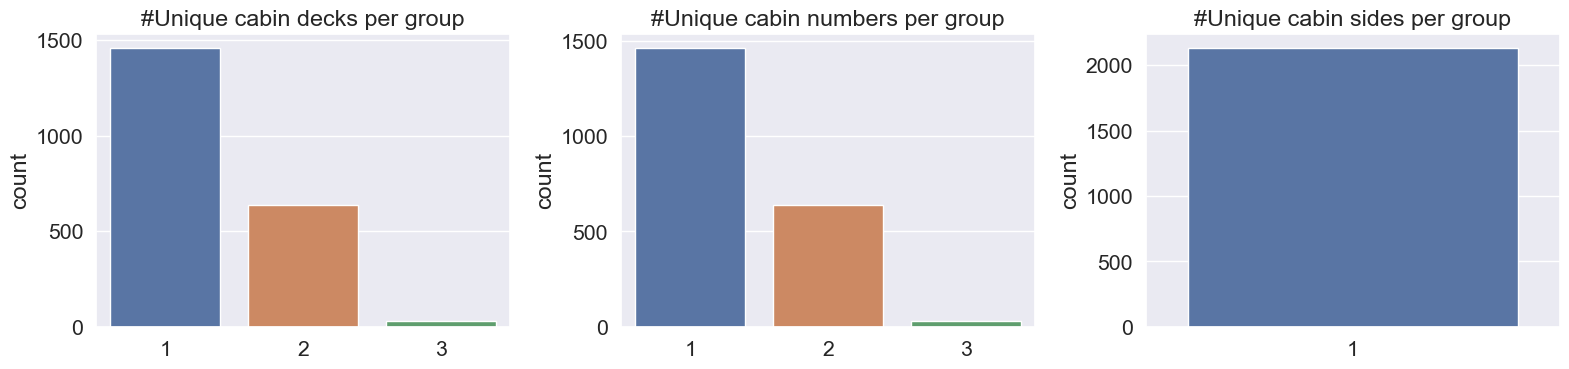

In [115]:
# Countplots
fig=plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.countplot(x=GCD_unique)
plt.title('#Unique cabin decks per group')

plt.subplot(1,3,2)
sns.countplot(x=GCN_unique)
plt.title('#Unique cabin numbers per group')

plt.subplot(1,3,3)
sns.countplot(x=GCS_unique)
plt.title('#Unique cabin sides per group')

fig.tight_layout()

Insights:
* Everyone in the same group is also on the same cabin side.
* For cabin deck and cabin number, there is also a fairly good (but not perfect) correlation with group.

In [116]:
# Missing values before
CS_bef = data['Cabin_side'].isna().sum()

# Passengers with missing Cabin side and in a group with known Cabin side
GCS_index = data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Group']).isin(GCS_gb.index)].index

# Fill corresponding missing values
data.loc[GCS_index, 'Cabin_side']=data.iloc[GCS_index,:]['Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Cabin_side missing values before:', CS_bef)
print('#Cabin_side missing values after:', data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 299
#Cabin_side missing values after: 162


### Cabin side and Surname

In [117]:
# Joint distribution of Surname and Cabin side
SCS_gb = data[data['Group_size']>1].groupby(['Surname', 'Cabin_side'])['Cabin_side'].size().unstack().fillna(0)
SCS_gb

Cabin_side,P,S
Surname,,
Acobson,0.0,3.0
Acobsond,3.0,0.0
Adavisons,6.0,0.0
Admingried,0.0,4.0
Aginge,3.0,0.0
...,...,...
Wriggins,0.0,3.0
Yanton,2.0,2.0
Yatters,0.0,3.0


Text(0.5, 1.0, 'Ratio of cabin side by surname')

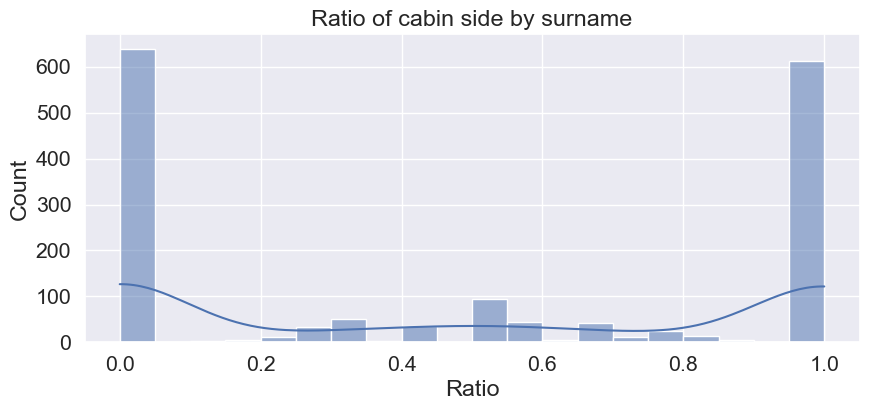

In [118]:
# Ratio of sides 
SCS_gb['Ratio'] = SCS_gb['P']/(SCS_gb['P']+SCS_gb['S'])

# Histogram of ratio
plt.figure(figsize=(10,4))
sns.histplot(SCS_gb['Ratio'], kde=True, binwidth=0.05)
plt.title('Ratio of cabin side by surname')

In [119]:
SCS_gb

Cabin_side,P,S,Ratio
Surname,,,
Acobson,0.0,3.0,0.000000
Acobsond,3.0,0.0,1.000000
Adavisons,6.0,0.0,1.000000
Admingried,0.0,4.0,0.000000
Aginge,3.0,0.0,1.000000
...,...,...,...
Wriggins,0.0,3.0,0.000000
Yanton,2.0,2.0,0.500000
Yatters,0.0,3.0,0.000000


In [120]:
# Print proportion
print('Percentage of families all on the same cabin side:', 100*np.round((SCS_gb['Ratio'].isin([0,1])).sum()/len(SCS_gb),3), '%')

Percentage of families all on the same cabin side: 76.7 %


This shows that families tend to be on the same cabin side.

In [121]:
SCS_gb.drop('Ratio', axis=1, inplace=True)

In [122]:
SCS_gb.head()

Cabin_side,P,S
Surname,,
Acobson,0.0,3.0
Acobsond,3.0,0.0
Adavisons,6.0,0.0
Admingried,0.0,4.0
Aginge,3.0,0.0


In [123]:
# Missing values before
CS_bef = data['Cabin_side'].isna().sum()

# Passengers with missing Cabin side and in a family with known Cabin side
SCS_index = data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Surname']).isin(SCS_gb.index)].index

# Fill corresponding missing values
data.loc[SCS_index, 'Cabin_side'] = data.iloc[SCS_index, :]['Surname'].map(lambda x: SCS_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Cabin_side missing values before:', CS_bef)
print('#Cabin_side missing values after:', data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 162
#Cabin_side missing values after: 66


The remaining missing values will be replaced with an outlier. This is because we really don't know which one of the two sides we should assign.

In [124]:
# Drop surname, we don't need it anymore
data.drop('Surname', axis=1, inplace=True)

In [125]:
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Age_group', 'Expenditure', 'No_spending', 'Group', 'Group_size',
       'Solo', 'Cabin_deck', 'Cabin_number', 'Cabin_side', 'Cabin_region1',
       'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5',
       'Cabin_region6', 'Cabin_region7', 'Family_size'],
      dtype='object')

In [126]:
data['Cabin_side'].value_counts()

Cabin_side
S    6504
P    6400
Name: count, dtype: int64

In [127]:
# Missing values before
CS_bef = data['Cabin_side'].isna().sum()

# Fill remaining missing values with outlier
data.loc[data['Cabin_side'].isna(), 'Cabin_side'] = 'Z'

# Print number of missing values left
print('#Cabin_side missing values before:', CS_bef)
print('#Cabin_side missing values after:', data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 66
#Cabin_side missing values after: 0


### Cabin deck and Group

In [128]:
# Missing values before
CD_bef = data['Cabin_deck'].isna().sum()

# Passengers with missing cabin deck and in a group with known majority cabin deck
GCD_index = data[data['Cabin_deck'].isna()][(data[data['Cabin_deck'].isna()]['Group']).isin(GCD_gb.index)].index

# Fill corresponding missing values
data.loc[GCD_index, 'Cabin_deck'] = data.iloc[GCD_index, :]['Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Cabin_deck missing values before:', CD_bef)
print('#Cabin_deck missing values after:', data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 299
#Cabin_deck missing values after: 162


### Cabin deck and HomePlanet

In [129]:
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Age_group', 'Expenditure', 'No_spending', 'Group', 'Group_size',
       'Solo', 'Cabin_deck', 'Cabin_number', 'Cabin_side', 'Cabin_region1',
       'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5',
       'Cabin_region6', 'Cabin_region7', 'Family_size'],
      dtype='object')

In [130]:
# Joint distribution
data.groupby(['HomePlanet', 'Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)

Cabin_deck,A,B,C,D,E,F,G,T
HomePlanet,,,,,,,,
Earth,0.0,0.0,0.0,0.0,601.0,2496.0,3821.0,0.0
Europa,361.0,1161.0,1122.0,309.0,204.0,0.0,0.0,11.0
Mars,0.0,0.0,0.0,421.0,529.0,1772.0,0.0,0.0


In [131]:
data.groupby(['HomePlanet', 'Solo', 'Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)

Cabin_deck           A      B      C      D      E       F       G    T
HomePlanet Solo                                                        
Earth      0       0.0    0.0    0.0    0.0  171.0   595.0  1577.0  0.0
           1       0.0    0.0    0.0    0.0  430.0  1901.0  2244.0  0.0
Europa     0     250.0  841.0  752.0  179.0   88.0     0.0     0.0  3.0
           1     111.0  320.0  370.0  130.0  116.0     0.0     0.0  8.0
Mars       0       0.0    0.0    0.0  208.0  243.0   916.0     0.0  0.0
           1       0.0    0.0    0.0  213.0  286.0   856.0     0.0  0.0

Notes:
* Passengers from Mars are most likely in deck F.
* Passengers from Europa are most likely in deck C if travelling solo and deck B otherwise.
* Passengers from Earth are most likely in deck G.


We will fill in missing values according to where the mode appears in these subgroups.

In [132]:
data.groupby(['HomePlanet', 'Destination', 'Solo', 'Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)

Cabin_deck                         A      B      C      D      E       F  \
HomePlanet Destination   Solo                                              
Earth      55 Cancri e   0       0.0    0.0    0.0    0.0   20.0    90.0   
                         1       0.0    0.0    0.0    0.0   47.0   289.0   
           PSO J318.5-22 0       0.0    0.0    0.0    0.0   18.0    67.0   
                         1       0.0    0.0    0.0    0.0   25.0   262.0   
           TRAPPIST-1e   0       0.0    0.0    0.0    0.0  133.0   438.0   
                         1       0.0    0.0    0.0    0.0  358.0  1350.0   
Europa     55 Cancri e   0      96.0  377.0  313.0   59.0   35.0     0.0   
                         1      67.0  141.0  159.0   46.0   34.0     0.0   
           PSO J318.5-22 0       2.0    5.0   11.0    0.0    0.0     0.0   
                         1       0.0    0.0   10.0    0.0    0.0     0.0   
           TRAPPIST-1e   0     152.0  459.0  428.0  120.0   53.0     0.0   
                         1      44.0  179.0  201.0   84.0   82.0     0.0   
Mars       55 Cancri e   0       0.0    0.0    0.0   32.0   15.0   104.0   
                         1       0.0    0.0    0.0   40.0   16.0    92.0   
           PSO J318.5-22 0       0.0    0.0    0.0    8.0    9.0    14.0   
                         1       0.0    0.0    0.0    9.0    7.0    21.0   
           TRAPPIST-1e   0       0.0    0.0    0.0  168.0  219.0   798.0   
                         1       0.0    0.0    0.0  164.0  263.0   743.0   

Cabin_deck                          G    T  
HomePlanet Destination   Solo               
Earth      55 Cancri e   0      272.0  0.0  
                         1      269.0  0.0  
           PSO J318.5-22 0      230.0  0.0  
                         1      466.0  0.0  
           TRAPPIST-1e   0     1075.0  0.0  
                         1     1509.0  0.0  
Europa     55 Cancri e   0        0.0  2.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  1.0  
                         1        0.0  8.0  
Mars       55 Cancri e   0        0.0  0.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  0.0  
                         1        0.0  0.0

In [133]:
# Missing values before
CD_bef = data['Cabin_deck'].isna().sum()

# Fill missing values using the mode
na_rows_CD = data.loc[data['Cabin_deck'].isna(), 'Cabin_deck'].index

data.loc[data['Cabin_deck'].isna(), 'Cabin_deck'] = data.groupby(
    ['HomePlanet', 'Destination', 'Solo'])['Cabin_deck'].transform(
    lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CD]

# Print number of missing values left
print('#Cabin_deck missing values before:', CD_bef)
print('#Cabin_deck missing values after:', data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 162
#Cabin_deck missing values after: 0


### Cabin number and cabin deck

Text(0.5, 1.0, 'Cabin_number vs group coloured by group')

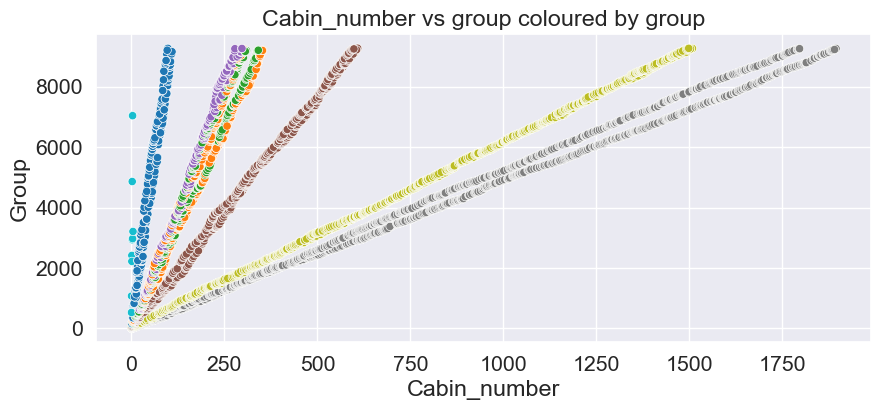

In [134]:
# Scatterplot
plt.figure(figsize=(10,4))
sns.scatterplot(
    x=data['Cabin_number'], 
    y=data['Group'], 
    c=LabelEncoder().fit_transform(data.loc[~data['Cabin_number'].isna(), 'Cabin_deck']), 
    cmap='tab10'
)

plt.title('Cabin_number vs group coloured by group')

There is an interesting pattern here. The cabin_number and group_number share a linear relationship on a deck by deck basis. We can therefore extrapolate the missing cabin numbers using linear regression on a deck by deck basis to get an approximate cabin number.

In [135]:
cabin_deck_list

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']

In [136]:
cabin_deck_list_new = [x for x in cabin_deck_list if x != 'T']
cabin_deck_list_new

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [137]:
# Missing values before
CN_bef = data['Cabin_number'].isna().sum()

# Extrapolate linear relationship on a deck by deck basis
for deck in cabin_deck_list_new:
    X_CN = data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck), 'Group']
    y_CN = data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck), 'Cabin_number']
    X_test_CN = data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck), 'Group']

    # Linear regression
    model_CN = LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
    preds_CN = model_CN.predict(X_test_CN.values.reshape(-1, 1))

    # Fill missing values with predictions
    data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck), 'Cabin_number'] = preds_CN.astype(int)

# Print number of missing values left
print('#Cabin_number missing values before:', CN_bef)
print('#Cabin_number missing values after:', data['Cabin_number'].isna().sum())

#Cabin_number missing values before: 299
#Cabin_number missing values after: 0


Update the cabin regions with the new data.

In [138]:
# One-hot encode cabin regions
data['Cabin_region1'] = (data['Cabin_number']<300).astype(int) 
data['Cabin_region2'] = ((data['Cabin_number']>=300) & (data['Cabin_number']<600)).astype(int)
data['Cabin_region3'] = ((data['Cabin_number']>=600) & (data['Cabin_number']<900)).astype(int)
data['Cabin_region4'] = ((data['Cabin_number']>=900) & (data['Cabin_number']<1200)).astype(int)
data['Cabin_region5'] = ((data['Cabin_number']>=1200) & (data['Cabin_number']<1500)).astype(int)
data['Cabin_region6'] = ((data['Cabin_number']>=1500) & (data['Cabin_number']<1800)).astype(int)
data['Cabin_region7'] = (data['Cabin_number']>=1800).astype(int)

In [139]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_number,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,0.0,P,1,0,0,0,0,0,0,4
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,0.0,S,1,0,0,0,0,0,0,4
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,0.0,S,1,0,0,0,0,0,0,7
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,0.0,S,1,0,0,0,0,0,0,7
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,1.0,S,1,0,0,0,0,0,0,9


## VIP

VIP is a highly unbalanced binary feature so we will just impute the mode.

In [140]:
data['VIP'].value_counts()

VIP
False    12401
True       273
Name: count, dtype: int64

In [141]:
# Missing values before
V_bef = data['VIP'].isna().sum()

# Fill missing values with code
data.loc[data['VIP'].isna(), 'VIP'] = False

# Print number of missing values left
print('#VIP missing values before:', V_bef)
print('#VIP missing values after:', data['VIP'].isna().sum())

#VIP missing values before: 296
#VIP missing values after: 0


## Age

Age varies across many features like HomePlanet, expenditure, group size and cabin deck, so we will impute missing values according to the median of these subgroups.

In [142]:
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Age_group', 'Expenditure', 'No_spending', 'Group', 'Group_size',
       'Solo', 'Cabin_deck', 'Cabin_number', 'Cabin_side', 'Cabin_region1',
       'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5',
       'Cabin_region6', 'Cabin_region7', 'Family_size'],
      dtype='object')

In [143]:
# Joint distribution
data.groupby(['HomePlanet', 'No_spending', 'Solo', 'Cabin_deck'])['Age'].median().unstack().fillna(0)

Cabin_deck                      A     B     C     D     E     F     G     T
HomePlanet No_spending Solo                                                
Earth      0           0      0.0   0.0   0.0   0.0  24.0  25.0  28.0   0.0
                       1      0.0   0.0   0.0   0.0  25.0  24.0  26.0   0.0
           1           0      0.0   0.0   0.0   0.0   7.0  16.0   8.0   0.0
                       1      0.0   0.0   0.0   0.0  21.0  21.5  23.0   0.0
Europa     0           0     35.0  34.0  33.0  33.0  34.0   0.0   0.0  44.0
                       1     35.0  36.0  35.5  34.0  35.0   0.0   0.0  35.0
           1           0     30.0  27.0  28.5  27.0  28.0   0.0   0.0   0.0
                       1     37.5  34.0  35.0  31.0  33.0   0.0   0.0   0.0
Mars       0           0      0.0   0.0   0.0  30.0  29.0  29.0   0.0   0.0
                       1      0.0   0.0   0.0  31.0  28.5  30.0   0.0   0.0
           1           0      0.0   0.0   0.0  29.5  26.0  18.0   0.0   0.0
                       1      0.0   0.0   0.0  33.0  30.0  29.5   0.0   0.0

In [144]:
exp_feats

['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [145]:
# Missing values before
A_bef = data[exp_feats].isna().sum().sum()

# Fill missing values using the median
na_rows_A = data.loc[data['Age'].isna(), 'Age'].index

data.loc[data['Age'].isna(), 'Age'] = data.groupby(
    ['HomePlanet', 'No_spending', 'Solo', 'Cabin_deck']
)['Age'].transform(lambda x: x.fillna(x.median()))[na_rows_A]

# Print number of missing values left
print('#Age missing values before:', A_bef)
print('#Age missing values after:', data['Age'].isna().sum())

#Age missing values before: 1410
#Age missing values after: 0


Update the age_group feature using the new data.

In [146]:
# Update age group feature
# data['Age_group'] = np.nan
data.loc[data['Age']<=12, 'Age_group'] = 'Age_0-12'
data.loc[(data['Age']>12) & (data['Age']<18), 'Age_group'] = 'Age_13-17'
data.loc[(data['Age']>=18) & (data['Age']<=25), 'Age_group'] = 'Age_18-25'
data.loc[(data['Age']>25) & (data['Age']<=30), 'Age_group'] = 'Age_26-30'
data.loc[(data['Age']>30) & (data['Age']<=50), 'Age_group'] = 'Age_31-50'
data.loc[data['Age']>50, 'Age_group'] = 'Age_51+'

In [147]:
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Age_group', 'Expenditure', 'No_spending', 'Group', 'Group_size',
       'Solo', 'Cabin_deck', 'Cabin_number', 'Cabin_side', 'Cabin_region1',
       'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5',
       'Cabin_region6', 'Cabin_region7', 'Family_size'],
      dtype='object')

## CryoSleep

The best way to predict if a passenger is in CryoSleep or not is to see if they spent anything.

In [148]:
# Joint distribution

data.groupby(['No_spending', 'CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
No_spending,,
0,7339.0,0.0
1,740.0,4581.0


In [149]:
# Missing values before
CSL_bef = data['CryoSleep'].isna().sum()

# Fill missing values using the mode
na_rows_CSL = data.loc[data['CryoSleep'].isna(), 'CryoSleep'].index
data.loc[data['CryoSleep'].isna(), 'CryoSleep'] = data.groupby(
    ['No_spending']
)['CryoSleep'].transform(
    lambda x: x.fillna(pd.Series.mode(x)[0])
)[na_rows_CSL]

# Print number of missing values left
print('#CryoSleep missing values before:', CSL_bef)
print('#CryoSleep missing values after:', data['CryoSleep'].isna().sum())

#CryoSleep missing values before: 310
#CryoSleep missing values after: 0


### Expenditure and CryoSleep

We don't expect people in CryoSleep to be able to spend anything.

In [150]:
print('Maximum expenditure of passengers in CryoSleep:', data.loc[data['CryoSleep']==True, exp_feats].sum(axis=1).max())

Maximum expenditure of passengers in CryoSleep: 0.0


In [151]:
# Missing values before
E_bef = data[exp_feats].isna().sum().sum()

# CryoSleep has no expenditure
for col in exp_feats:
    data.loc[(data[col].isna()) & (data['CryoSleep']==True), col] = 0

# Print number of missing values left
print('#Expenditure missing values before:', E_bef)
print('#Expenditure missing values after:', data[exp_feats].isna().sum().sum())

#Expenditure missing values before: 1410
#Expenditure missing values after: 866


### Expenditure and others

In [152]:
# Joint distribution
data.groupby(['HomePlanet', 'Solo', 'Age_group'])['Expenditure'].mean().unstack().fillna(0)

Age_group        Age_0-12    Age_13-17    Age_18-25    Age_26-30    Age_31-50  \
HomePlanet Solo                                                                 
Earth      0          0.0   724.902222   789.700555   841.093596   736.655773   
           1          0.0   693.014898   779.395942   795.420690   794.818627   
Europa     0          0.0  1153.160256  2652.013298  3534.668246  3975.774005   
           1          0.0     0.000000  2489.888889  3806.000000  3949.939929   
Mars       0          0.0  1176.839286  1161.808333  1247.098361  1143.671916   
           1          0.0  1687.261538  1075.341146  1107.122677  1110.392045   

Age_group            Age_51+  
HomePlanet Solo               
Earth      0      733.649573  
           1      826.366972  
Europa     0     3483.639004  
           1     3952.085526  
Mars       0     1345.419643  
           1     1100.298387

Expenditure varies across many features but we will only impute missing values using HomePlanet, Solo and Age group to prevent overfitting. We will also use the mean instead of the median because a large proportion of passengers don't spend anything and median usually comes out as 0.

In [153]:
# Missing values before
E_bef = data[exp_feats].isna().sum().sum()

# Fill remaining missing values using the median
for col in exp_feats:
    na_rows = data.loc[data[col].isna(), col].index
    data.loc[data[col].isna(), col] = data.groupby(['HomePlanet', 'Solo', 'Age_group'])[col].transform(
        lambda x: x.fillna(x.mean())
    )[na_rows]

# Print number of missing values left
print('#Expenditure missing values before:', E_bef)
print('#Expenditure missing values after:', data[exp_feats].isna().sum().sum())

#Expenditure missing values before: 866
#Expenditure missing values after: 0


In [154]:
# Update expenditure and no_spending
data['Expenditure'] = data[exp_feats].sum(axis=1)
data['No_spending'] = (data['Expenditure']==0).astype(int)

In [155]:
data.isna().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Age_group        0
Expenditure      0
No_spending      0
Group            0
Group_size       0
Solo             0
Cabin_deck       0
Cabin_number     0
Cabin_side       0
Cabin_region1    0
Cabin_region2    0
Cabin_region3    0
Cabin_region4    0
Cabin_region5    0
Cabin_region6    0
Cabin_region7    0
Family_size      0
dtype: int64

# Preprocessing

In [156]:
# split data back into train and test sets

X = data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
X_test = data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

In [157]:
X.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Age_group', 'Expenditure', 'No_spending', 'Group', 'Group_size',
       'Solo', 'Cabin_deck', 'Cabin_number', 'Cabin_side', 'Cabin_region1',
       'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5',
       'Cabin_region6', 'Cabin_region7', 'Family_size'],
      dtype='object')

In [158]:
# Drop qualitative/redundant/collinear/high cardinality features
X.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)

In [159]:
X.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure',
       'No_spending', 'Solo', 'Cabin_deck', 'Cabin_side', 'Cabin_region1',
       'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5',
       'Cabin_region6', 'Cabin_region7', 'Family_size'],
      dtype='object')

### Log transform

The logarithmn transform is used to decrease skew in distributions, expecially with large outliers. It can make it easier for algorithms to 'learn' the correct relationships. We will apply it to the expenditure features as these are heavily skewed by outliers.

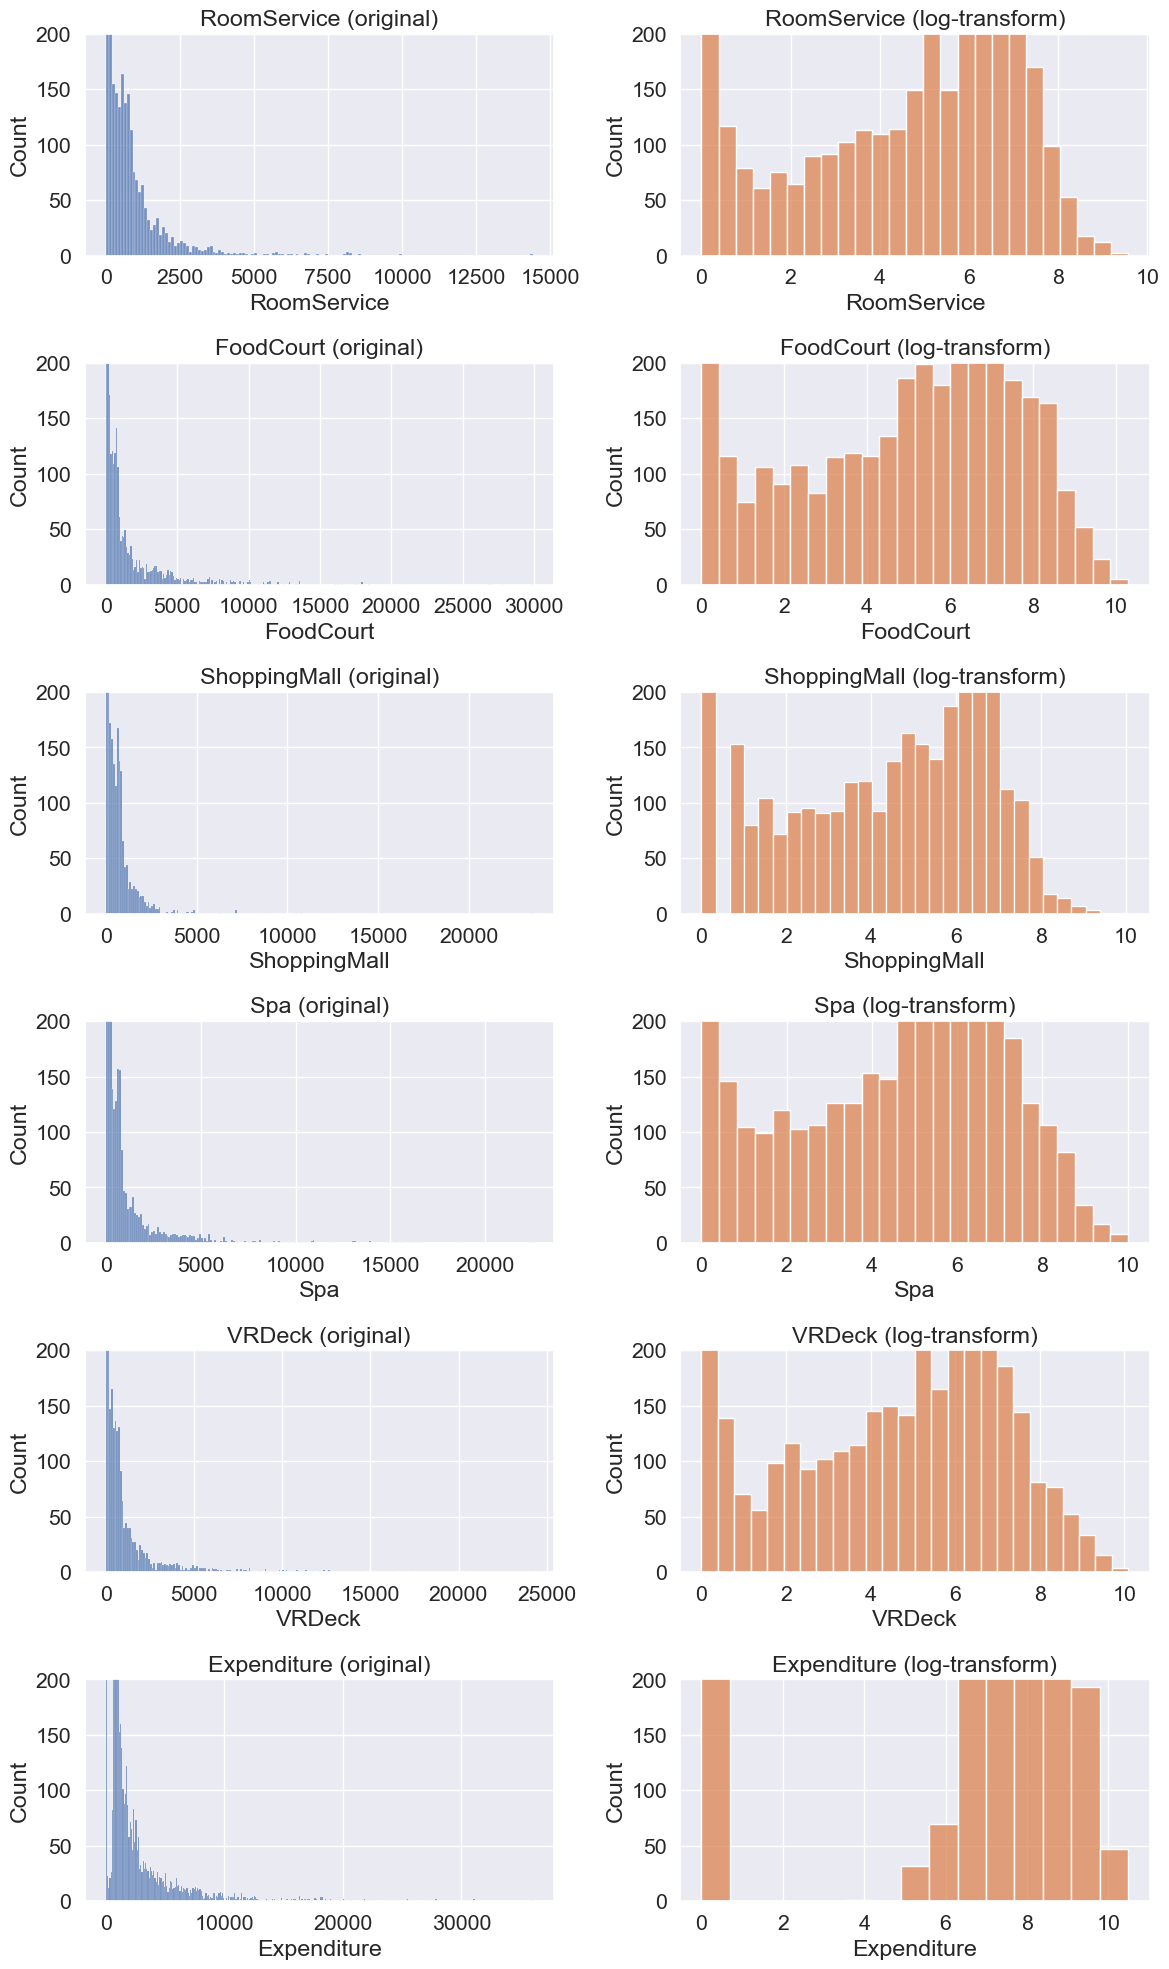

In [160]:
# Plot log transform results
fig = plt.figure(figsize = (12, 20))
for i, col in enumerate(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure']):
    plt.subplot(6, 2, 2*i+1)
    sns.histplot(X[col], binwidth=100)
    plt.ylim([0, 200])
    plt.title(f'{col} (original)')

    plt.subplot(6, 2, 2*i+2)
    sns.histplot(np.log(1+X[col]), color='C1')
    plt.ylim([0, 200])
    plt.title(f'{col} (log-transform)')

fig.tight_layout()
plt.show()

In [161]:
# Apply log transform
for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure']:
    X[col] = np.log(1+X[col])
    X_test[col] = np.log(1+X_test[col])

### Encoding and scaling

In [162]:
X.shape

(8693, 23)

In [163]:
# Indentify numerical and categorical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Scale numerical data to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[(
    'onehot',
    OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)
)])

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# Apply preprocessing
X = ct.fit_transform(X)
X_test = ct.transform(X_test)

# Print new shape
print('Training set shape:', X.shape)

Training set shape: (8693, 36)


### PCA

Let's look at the transformed data in PCA space. This gives a low dimensional representation of the data, which preserves local and global structure.

In [164]:
pca = PCA(n_components = 3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y, size=0.1*np.ones(len(X)), opacity = 1,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width=800, height=500
)

fig.show()

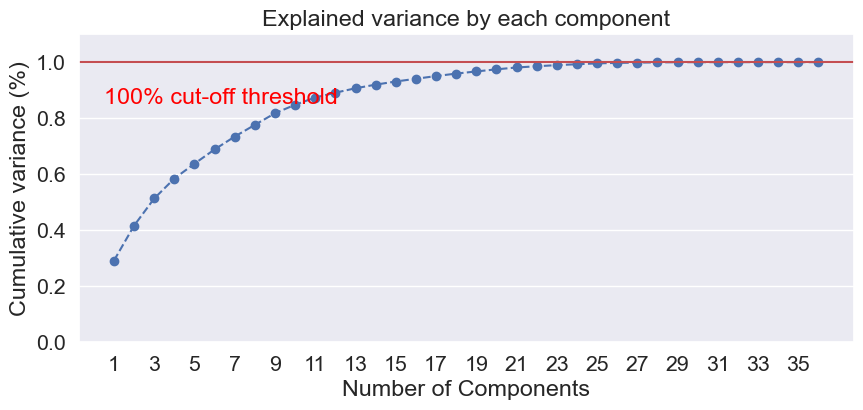

In [165]:
# Explained variance (how important each additional principal component is)
pca = PCA().fit(X)
fig, ax = plt.subplots(figsize=(10, 4))
xi = np.arange(1, 1+X.shape[1], step=1)
yi = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

plt.ylim(0.0, 1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+X.shape[1], step=2))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance by each component')
plt.axhline(y=1, color='r', linestyle='-')
plt.text(0.5, 0.85, '100% cut-off threshold', color='red')
ax.grid(axis='x')

### Create a validation set

We will use this to choose which models to use.

In [166]:
# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, stratify = y, train_size = 0.8, test_size = 0.2, random_state=0
)

# Model Selection

* Logistic Regression
* K-Nearest Neighbors (KNN)
* Support Vector Machine (SVM)
* Random Forest (RF)
* Extreme Gradient Boosting (XGBoost)
* Light Gradient Boosting Machine (LGBM)
* Categorical Boosting (CatBoost)
* Naive Bayes (NB)

We will train these models and evaluate them on the validation set to then choose which ones to carry to the next stage (cross validation)

### Define classifiers

In [167]:
# Classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(random_state=0, probability=True),
    "RandomForest": RandomForestClassifier(random_state=0),
    "XGBoost": XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'),
    "LGBM": LGBMClassifier(random_state=0),
    "CatBoost": CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB()
}

In [168]:
# Grids for grid search
LR_grid = {'penalty': ['l1', 'l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]
          }

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]
           }

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
           }
RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
          'max_depth': [4, 6, 8, 10, 12]
          }

boosted_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [4, 8, 12],
    'learning_rate': [0.05, 0.1, 0.15]
}

NB_grid = {'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids

grid = {
    "LogisticRegression": LR_grid,
    "KNN": KNN_grid,
    "SVC": SVC_grid,
    "RandomForest": RF_grid,
    "XGBoost": boosted_grid,
    "LGBM": boosted_grid,
    "CatBoost": boosted_grid,
    "NaiveBayes": NB_grid
}

### Train and evaluate models

Train models with grid search (but no cross validation so it doesn't take too long) to get a rough idea of which are the best models for this dataset.

In [169]:
i = 0
clf_best_params = classifiers.copy()
valid_scores = pd.DataFrame({
    'Classifier': classifiers.keys(),
    'Validation accuracy': np.zeros(len(classifiers)),
    'Training time': np.zeros(len(classifiers))
})

In [170]:
clf_best_params

{'LogisticRegression': LogisticRegression(random_state=0),
 'KNN': KNeighborsClassifier(),
 'SVC': SVC(probability=True, random_state=0),
 'RandomForest': RandomForestClassifier(random_state=0),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=0, ...),
 'LGBM': LGBMClassifie

In [171]:
valid_scores

,Classifier,Validation accuracy,Training time
0,LogisticRegression,0.0,0.0
1,KNN,0.0,0.0
2,SVC,0.0,0.0
3,RandomForest,0.0,0.0
4,XGBoost,0.0,0.0
5,LGBM,0.0,0.0
6,CatBoost,0.0,0.0
7,NaiveBayes,0.0,0.0


In [172]:
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator = classifier,
                      param_grid = grid[key],
                      n_jobs = -1,
                      cv = None)
    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i, 1] = clf.score(X_valid, y_valid)

    # Save trained model
    clf_best_params[key] = clf.best_params_

    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i, 2] = np.round((stop - start)/60, 2)

    print('Model: ', key)
    print('Training time (mins): ', valid_scores.iloc[i, 2])
    print('')
    i+=1

Model:  LogisticRegression
Training time (mins):  0.1

Model:  KNN
Training time (mins):  0.03

Model:  SVC
Training time (mins):  3.07

Model:  RandomForest
Training time (mins):  0.35

Model:  XGBoost
Training time (mins):  0.25

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1687
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [173]:
valid_scores

,Classifier,Validation accuracy,Training time
0,LogisticRegression,0.769983,0.10
1,KNN,0.756757,0.03
2,SVC,0.793560,3.07
3,RandomForest,0.790109,0.35
4,XGBoost,0.801610,0.25
5,LGBM,0.797585,0.56
6,CatBoost,0.808511,6.60
7,NaiveBayes,0.719379,0.00


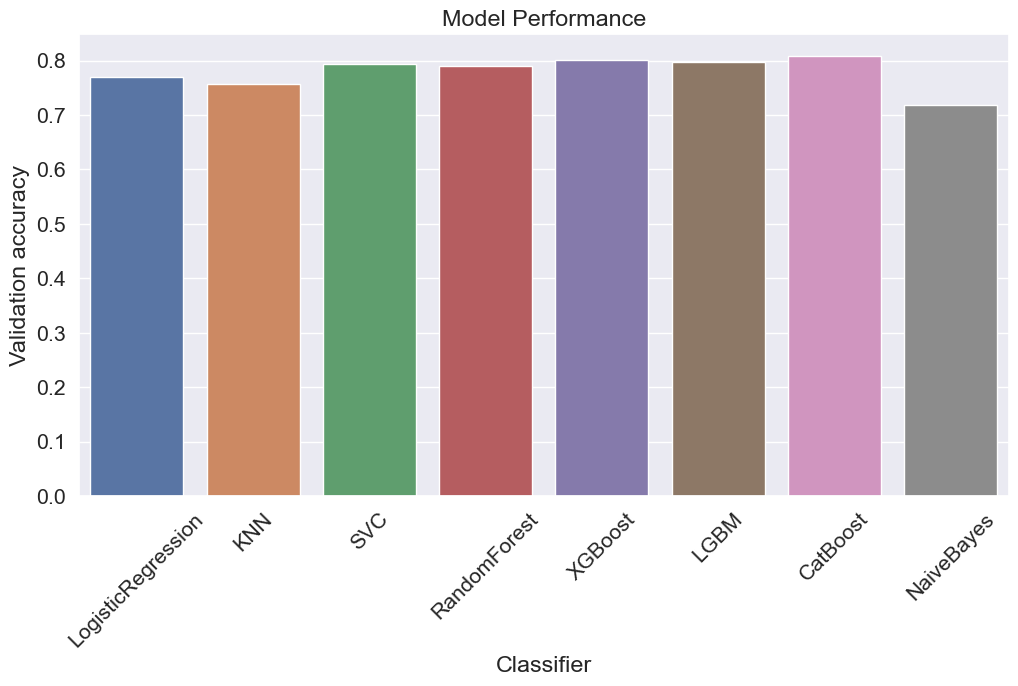

In [174]:
plt.figure(figsize=(12, 6))

# 使用 seaborn 绘制柱状图
sns.barplot(x='Classifier', y='Validation accuracy', data=valid_scores)

# 添加标题和标签
plt.title('Model Performance')
plt.xlabel('Classifier')
plt.ylabel('Validation accuracy')

plt.xticks(rotation=45)

# 显示图表
plt.show()

We will take XGBoost, LGBM and CatBoost to the final stage of modelling.

In [175]:
# show best parameters from grid search
clf_best_params

{'LogisticRegression': {'C': 0.75, 'max_iter': 100, 'penalty': 'l2'},
 'KNN': {'n_neighbors': 9, 'p': 1},
 'SVC': {'C': 1.25, 'gamma': 'scale', 'kernel': 'rbf'},
 'RandomForest': {'max_depth': 12, 'n_estimators': 150},
 'XGBoost': {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100},
 'LGBM': {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100},
 'CatBoost': {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 150},
 'NaiveBayes': {'var_smoothing': 1e-07}}

# Modelling

We can finally train our best model on the whole training set using crossing validation and ensembling predictions together to produce the most confident predications.

In [176]:
# Define best models

best_classifiers = {
    'XGBoost': XGBClassifier(
        **clf_best_params["XGBoost"], 
        random_state=0, 
        use_label_encoder=False, 
        eval_metric='logloss'),
    'LGBM': LGBMClassifier(**clf_best_params["LGBM"], random_state=0),
    'CatBoost': CatBoostClassifier(**clf_best_params["CatBoost"], random_state=0, verbose=False)
}

### Cross validation and ensembling predictions

Predictions are ensembled together using soft voting. This averages the predicted probabilities to produce the most confident predictions.

In [177]:
# number of folds in cross validation 
FOLDS = 10
preds = np.zeros(len(X_test))

In [178]:
preds

array([0., 0., 0., ..., 0., 0., 0.])

In [179]:
for key, classifier in best_classifiers.items():
    start = time.time()
    # 10-fold cross validation
    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)

    score = 0
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # Get training and validation sets
        X_train, X_valid = X[train_idx], X[val_idx]
        y_train, y_valid = y[train_idx], y[val_idx]

        # Train model
        clf = classifier
        clf.fit(X_train, y_train)

        # Make predictions and measure accuracy
        preds += clf.predict_proba(X_test)[:,1]
        score += clf.score(X_valid, y_valid)

    # Average accuracy
    score = score/FOLDS

    # Stop timer
    stop = time.time()

    # Print accuracy and time
    print('Model: ', key)
    print('Average validation accuracy: ', np.round(100*score, 2))
    print('Training time (mins): ', np.round((stop - start)/60, 2))
    print('')

# Ensemble predictions
preds = preds/(FOLDS * len(best_classifiers))

Model:  XGBoost
Average validation accuracy:  81.1
Training time (mins):  0.02

[LightGBM] [Info] Number of positive: 3940, number of negative: 3883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1687
[LightGBM] [Info] Number of data points in the train set: 7823, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503643 -> initscore=0.014573
[LightGBM] [Info] Start training from score 0.014573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3940, number of negative: 3883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1687
[LightGBM] [Info] Number of data points in the train set: 7823, number of used features: 35

# Submission

Text(0.5, 0, 'Probability')

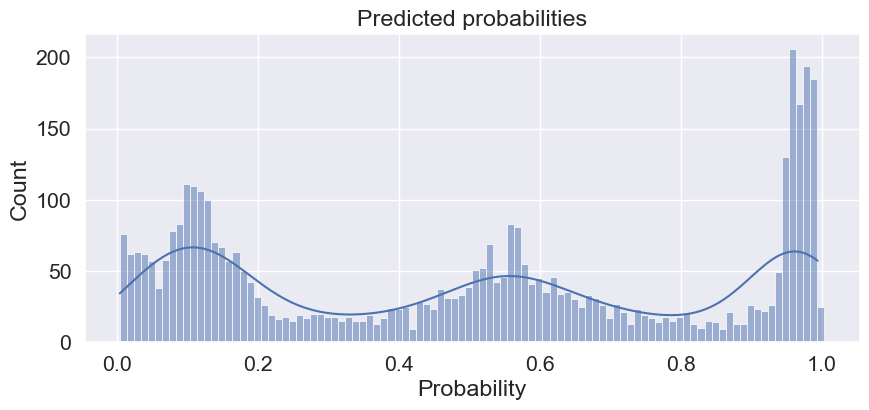

In [180]:
# distribution of the predicted probabilities

plt.figure(figsize=(10, 4))
sns.histplot(preds, binwidth=0.01, kde=True)
plt.title('Predicted probabilities')
plt.xlabel('Probability')

It is interesting to see that the models are either very confident or very unconfident but not much in between.

### Post processing

Finally, we need to convert each predicted probability into one of the two classes (transported or not). The simplest way is to round each probability to the nearest integer (0 for False or 1 for True). However, assuming the train and test sets have similar distributions, we can tune the classification threshold to obtain a similar proportation of transported/not transported in our predictions as in the train set. Remember that the proportion of transported passengers in the train set was 50.4%.



In [181]:
preds

array([0.56096654, 0.03090706, 0.9938362 , ..., 0.95778098, 0.73323515,
       0.60884085])

In [182]:
np.round(preds)

array([1., 0., 1., ..., 1., 1., 1.])

In [183]:
# Proportion in test set we get from rounding

print(np.round(100*np.round(preds).sum()/len(preds), 2))

52.84


Our models seem to overestimate the number of transported passengers in the test set. Let's bring that proportion down a bit.

Optimal threshold:  0.509


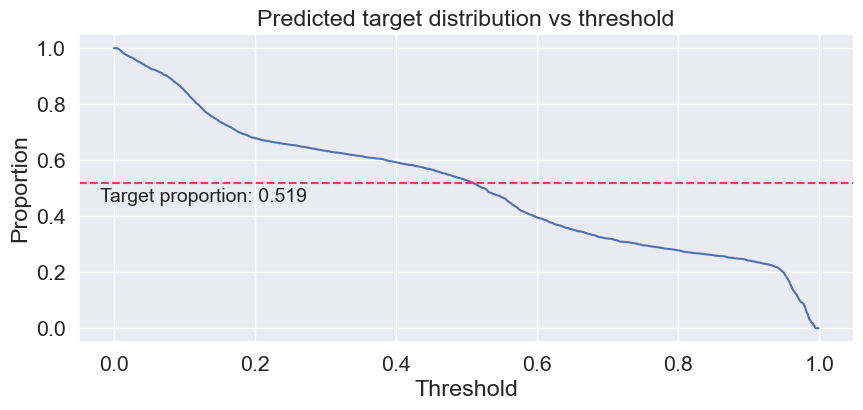

In [184]:
# Proportion of predicted positive (transported) classes
def preds_prop(preds_arr, thresh):
    pred_classes = (preds_arr >= thresh).astype(int)
    return pred_classes.sum()/len(pred_classes)

# Plot proportions across a range of thresholds
def plot_preds_prop(preds_arr):
    # array of thresholds
    T_array = np.arange(0, 1, 0.001)

    # calculate proportions
    prop = np.zeros(len(T_array))
    for i, T in enumerate(T_array):
        prop[i] = preds_prop(preds_arr, T)

    # plot proportions
    plt.figure(figsize=(10, 4))
    plt.plot(T_array, prop)
    target_prop=0.519 # experiment with this value
    plt.axhline(y=target_prop, color='r', linestyle='--')
    plt.text(-0.02, 0.45, f'Target proportion: {target_prop}', fontsize=14)
    plt.title('Predicted target distribution vs threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Proportion')

    # find optimal threshold (the one that leads to the proportion being cloest to target_prop)
    T_opt = T_array[np.abs(prop - target_prop).argmin()]
    print('Optimal threshold: ', T_opt)
    return T_opt

T_opt = plot_preds_prop(preds)

In [185]:
# classify test set using optimal threshold
preds_tuned = (preds >= T_opt).astype(int)

In [186]:
preds_tuned

array([1, 0, 1, ..., 1, 1, 1])

## Submit predictions

In [188]:
# sample submission (to get right format)
sub = pd.read_csv('data/sample_submission.csv')

sub

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


Text(0.5, 1.0, 'Prediction distribution')

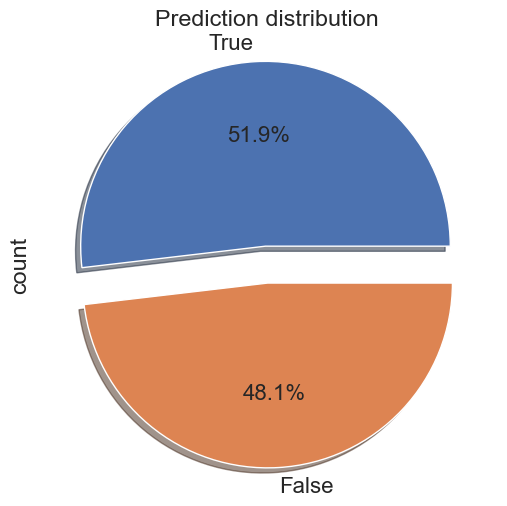

In [189]:
# Add predictions
sub['Transported'] = preds_tuned

# Replace 0 to False and 1 to True
sub = sub.replace({0: False, 1: True})

# Prediction distribution
plt.figure(figsize = (6, 6))
sub['Transported'].value_counts().plot.pie(
    explode= [0.1, 0.1], 
    autopct='%1.1f%%', 
    shadow=True, 
    textprops={'fontsize': 16}).set_title("Prediction distribution")

In [190]:
sub.to_csv('submission.csv', index=False)